<a href="https://colab.research.google.com/github/gayecolakoglu/Malaria_Detection_Deep_Learning/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
import tensorflow as tf
import tensorflow_addons as tfa
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/Colab Notebooks/ML/CLAHE/', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 10214 files [03:53, 43.82 files/s] 


In [6]:
#this directory contains same data, we can delete it
#import shutil

#shutil.rmtree('/content/gdrive/MyDrive/Colab Notebooks/ML/cell_images/cell_images')

In [7]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output', ['train', 'val'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [9]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [10]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=2)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

74836368/74836368 [==============================] - 3s 0us/step


In [11]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)

224/224 [==============================] - 43s 135ms/step


In [12]:
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

64/64 [==============================] - 11s 166ms/step


In [ ]:
'''
from keras import backend

def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon()))
'''

In [17]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=2,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [18]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [19]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.90402, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90402 to 0.90989, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90989 to 0.91871, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.91871 to 0.93144, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.93144 to 0.93781, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.93781 to 0.94564, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.94564 to 0.94760, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.94760 to 0.95152, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.95152

Epoch 11: val_accuracy improved from 0.95152 to 0.95446, saving model to DR.h5

Epoch 12: val_accuracy did not improve from 0.95446

Epoch 13: val_accura

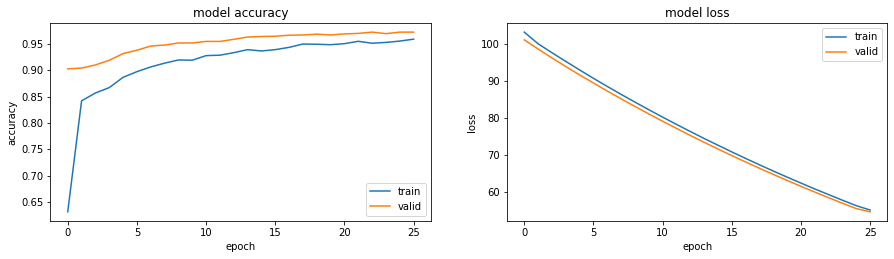


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 1s 6ms/step - loss: 54.5524 - accuracy: 0.9721

Epoch 1: val_accuracy improved from -inf to 0.88492, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.88492 to 0.90108, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90108 to 0.90255, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.90255

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.90255

Epoch 6: val_accuracy did not improve from 0.90255
Epoch 6: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 49.7225 - accuracy: 0.9025

LOSS:	49.722511291503906 	 ACCURACY:	0.9025465250015259
[49.722511291503906, 0.9025465250015259]



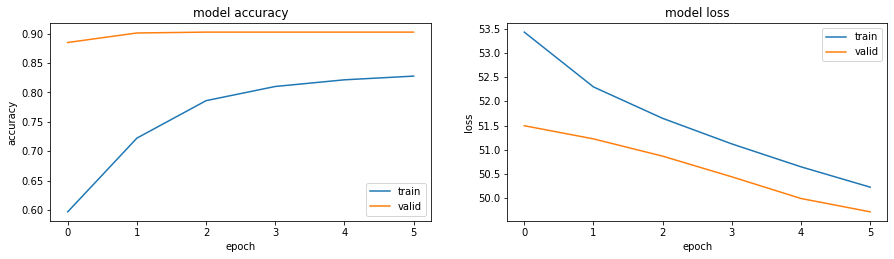


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 54.5524 - accuracy: 0.9721

Epoch 1: val_accuracy improved from -inf to 0.93389, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93389 to 0.94711, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94711 to 0.96425, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96425 to 0.97013, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97013 to 0.97111, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97111 to 0.97747, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.97747 to 0.97845, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.97845

Epoch 9: val_accuracy improved from 0.97845 to 0.98090, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.98090

Epoch 11: val_accuracy improved from 0.98090 to 0.98433, saving model to DR.h5

Epoch 12: va

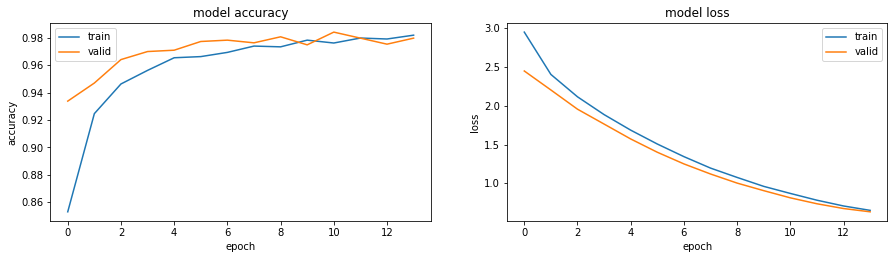


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.88639, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.88639 to 0.90255, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.90255

Epoch 5: val_accuracy did not improve from 0.90255
Epoch 5: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 1.6661 - accuracy: 0.9021

LOSS:	1.666124701499939 	 ACCURACY:	0.9020568132400513
[1.666124701499939, 0.9020568132400513]



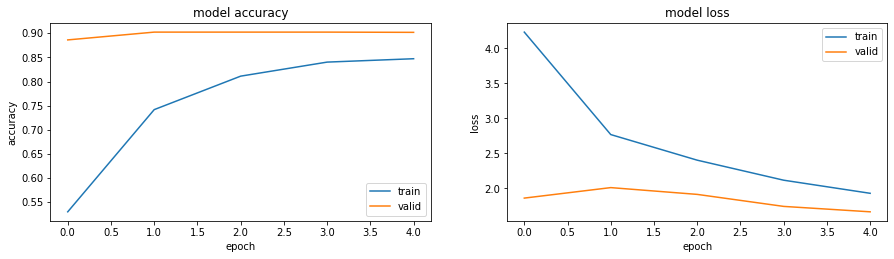


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.91283, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91283 to 0.92899, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.92899 to 0.93683, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.93683 to 0.94956, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.94956 to 0.95544, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.95544 to 0.95691, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.95691 to 0.95788, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.95788 to 0.95984, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.95984 to 0.96278, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.96278 to 0.96621, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

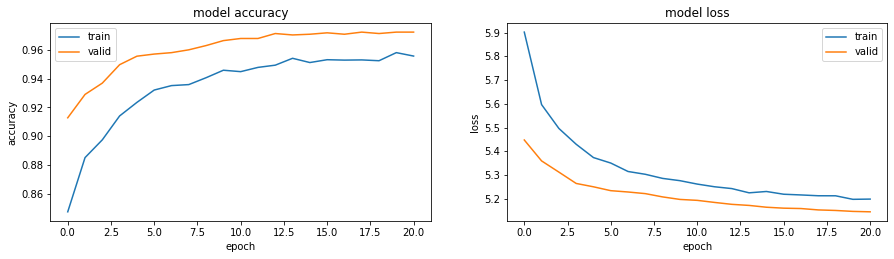




Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.90500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90500 to 0.91528, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.91528 to 0.92507, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.92507 to 0.93095, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.93095 to 0.94025, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94025 to 0.94172, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.94172

Epoch 8: val_accuracy improved from 0.94172 to 0.94564, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.94564 to 0.94858, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.94858 to 0.95054, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.95054 to 0.95250, saving 

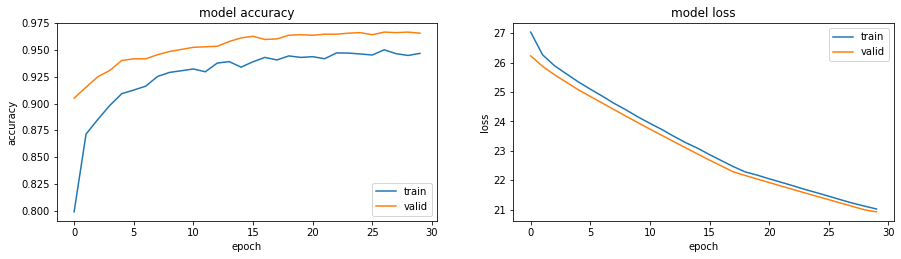


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.81244, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.81244 to 0.87610, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.87610 to 0.89471, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.89471 to 0.90500, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90500 to 0.90695, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90695 to 0.90744, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90744 to 0.90793, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90793

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 9: val_accuracy did not improve from 0.90793

Epoch 10: val_accuracy did not improve from 0.90793
Epoch 10: early stopping
64/64 [============

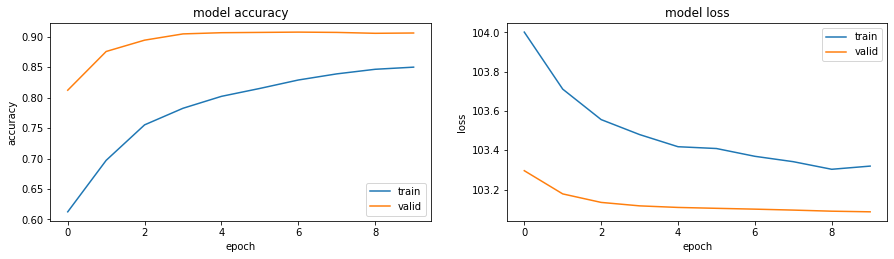


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.91185, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91185 to 0.94564, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94564 to 0.94760, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.94760 to 0.96131, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.96131

Epoch 6: val_accuracy improved from 0.96131 to 0.96327, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.96327 to 0.96719, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.96719 to 0.96915, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96915 to 0.97111, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97111 to 0.97160, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.97160

Epoch 12: val

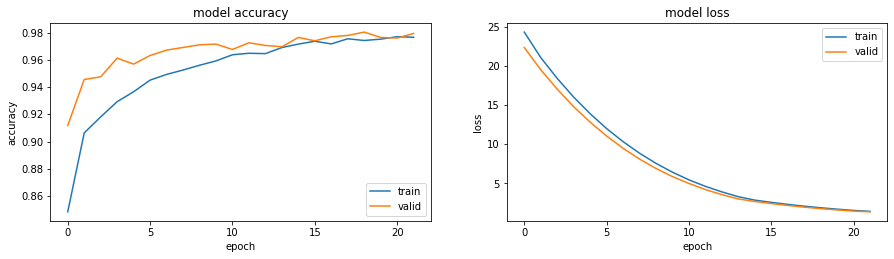


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.90500, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90500 to 0.91136, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.91136 to 0.91724, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.91724 to 0.92067, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.92067 to 0.92556, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.92556 to 0.93193, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.93193 to 0.93683, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.93683 to 0.93732, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.93732 to 0.94025, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

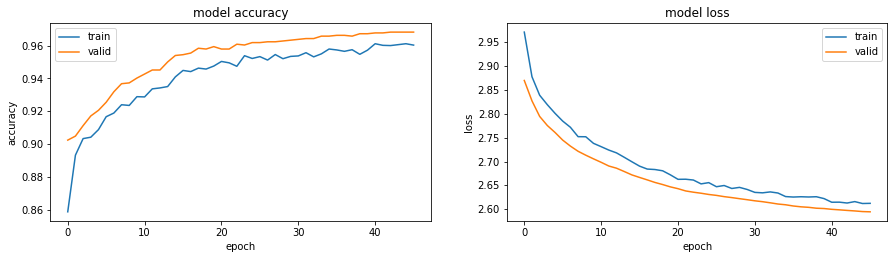


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.6338 - accuracy: 0.9799

Epoch 1: val_accuracy improved from -inf to 0.96082, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.96082 to 0.97453, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97453 to 0.98090, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.98090 to 0.98139, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.98139 to 0.98433, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.98433

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.98433

Epoch 8: val_accuracy did not improve from 0.98433
Epoch 8: early stopping

Epoch 4: val_accuracy improved from 0.90548 to 0.90940, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90940 to 0.91087, saving model to DR.h5

Epoch 6: val_accurac

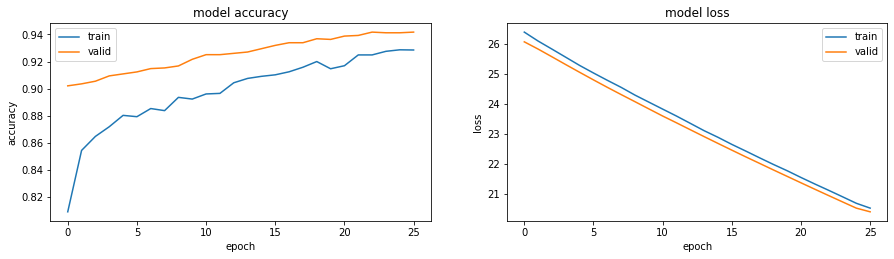


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90353, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90353 to 0.90402, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90402

Epoch 4: val_accuracy improved from 0.90402 to 0.90548, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90548 to 0.90646, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90646 to 0.90842, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90842 to 0.91087, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91087 to 0.91136, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91136 to 0.91577, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.91577 to 0.91773, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.91773 to 0.91920, saving mo

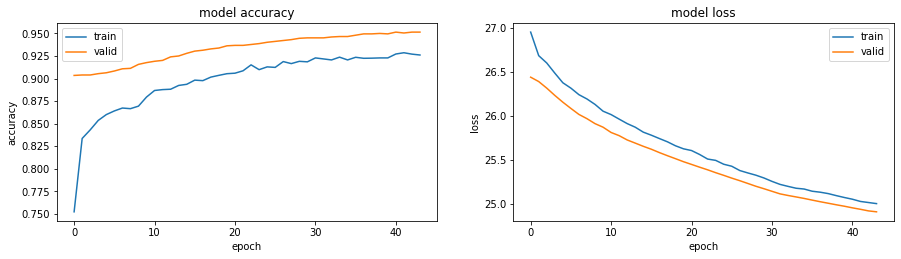


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.97356, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.97356

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.97356

Epoch 4: val_accuracy improved from 0.97356 to 0.97600, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97600 to 0.98335, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.98335

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.98335

Epoch 8: val_accuracy did not improve from 0.98335
Epoch 8: early stopping
64/64 [==============================] - 0s 6ms/step - loss: 0.1039 - accuracy: 0.9824

LOSS:	0.10392025858163834 	 ACCURACY:	0.9823701977729797
[0.10392025

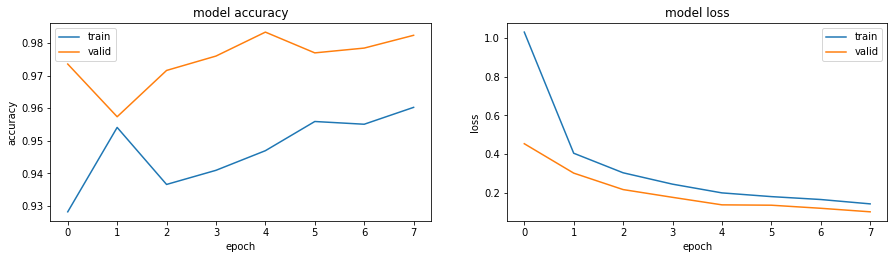


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 1s 5ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.94858, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.94858 to 0.96866, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96866 to 0.97698, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97698

Epoch 5: val_accuracy improved from 0.97698 to 0.97747, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97747 to 0.97845, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.97845

Epoch 8: val_accuracy improved from 0.97845 to 0.98237, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.98237

Epoch 10: val_accuracy improved from 0.98237 to 0.98384, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.98384

Epoch 12: ReduceLROnPlateau reducing learning rate to 5.99999984842

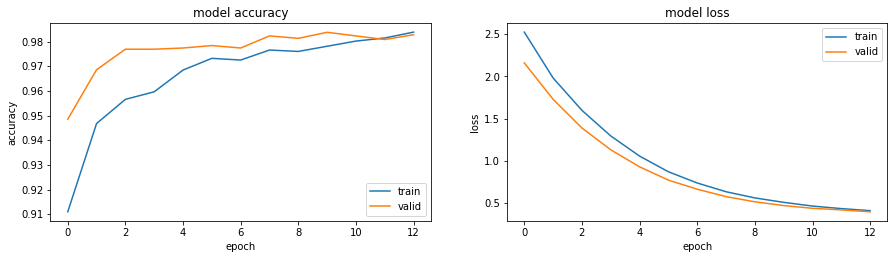


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 0.8277 - accuracy: 0.9025

LOSS:	0.8276976943016052 	 ACCURACY:	0.9025465250015259
[0.8276976943016052, 0.9025465250015259]



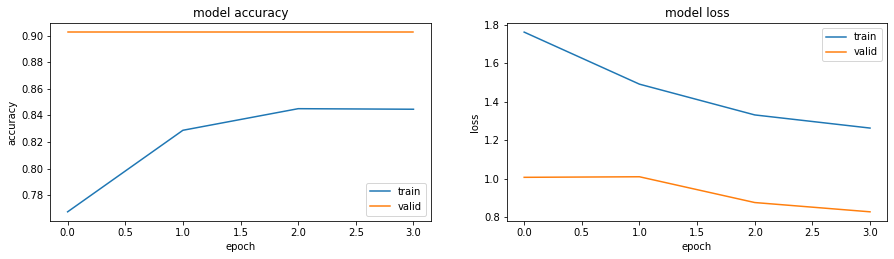


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: val_accuracy improved from 0.90255 to 0.90402, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90402 to 0.90451, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90451 to 0.90646, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90646 to 0.90793, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90793 to 0.91283, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91283 to 0.91822, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91822 to 0.92165, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.92165 to 0.92409, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.92409 to 0.92507, saving mo

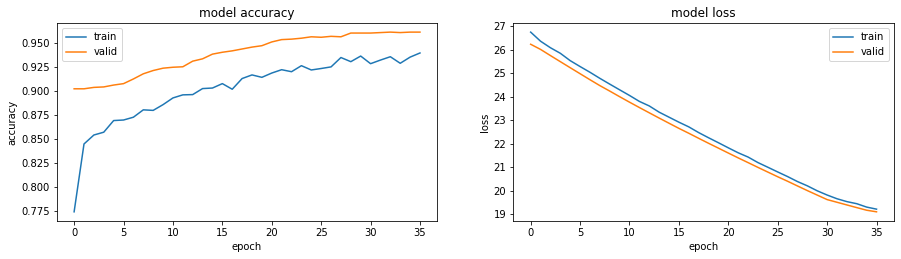


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.93144, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93144 to 0.94074, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94074 to 0.96376, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96376 to 0.97013, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.97013

Epoch 6: val_accuracy improved from 0.97013 to 0.97600, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.97600

Epoch 8: val_accuracy improved from 0.97600 to 0.97796, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.97796

Epoch 10: val_accuracy improved from 0.97796 to 0.97943, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.97943

Epoch 12: val_accuracy improved from 0.97943 to 0.97992, saving mod

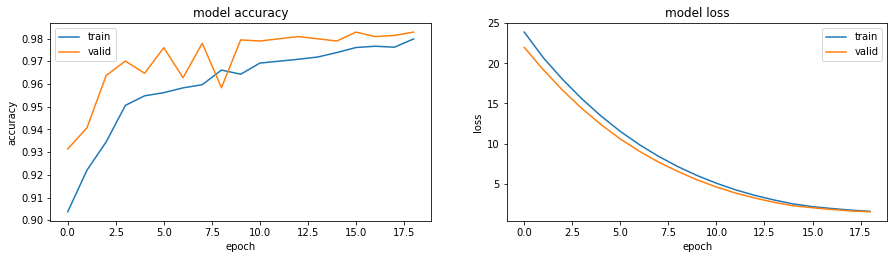


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90842, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90842 to 0.91332, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.91332 to 0.92214, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.92214 to 0.92997, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.92997 to 0.93487, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.93487 to 0.93928, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.93928 to 0.94417, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.94417 to 0.94809, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.94809 to 0.95103, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.95103 to 0.95299, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

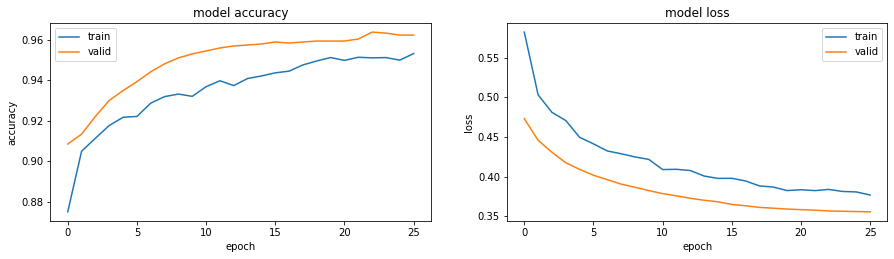


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90010, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90010 to 0.90744, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90744 to 0.92116, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.92116 to 0.94025, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.94025 to 0.94858, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94858 to 0.95593, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.95593 to 0.96180, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.96180 to 0.96621, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96621 to 0.96866, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.96866 to 0.96964, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

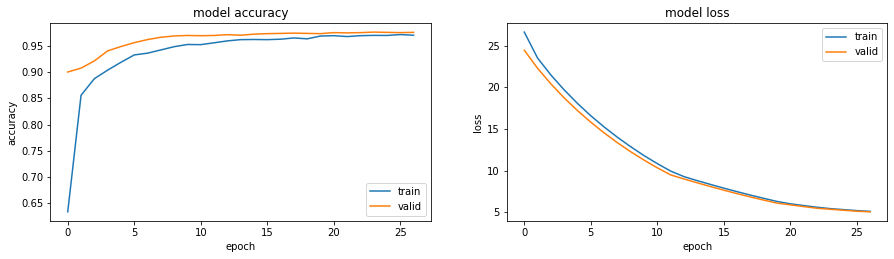


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.91724, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91724 to 0.92654, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.92654 to 0.93095, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.93095 to 0.93683, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.93683 to 0.94074, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94074 to 0.94662, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.94662 to 0.95201, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.95201

Epoch 9: val_accuracy improved from 0.95201 to 0.95495, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.95495 to 0.95593, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.95593 to 0.95642, saving mo

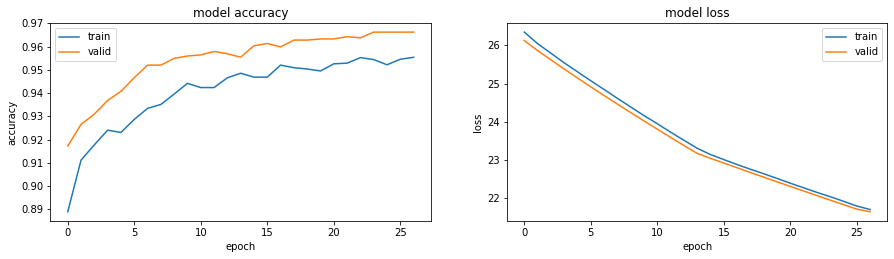


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.77571, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.77571 to 0.83252, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.83252 to 0.86043, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.86043 to 0.87855, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.87855 to 0.88883, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.88883 to 0.89569, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89569 to 0.90010, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90010

Epoch 9: val_accuracy improved from 0.90010 to 0.90206, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.90206 to 0.90255, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.90255

Epoch 12: Red

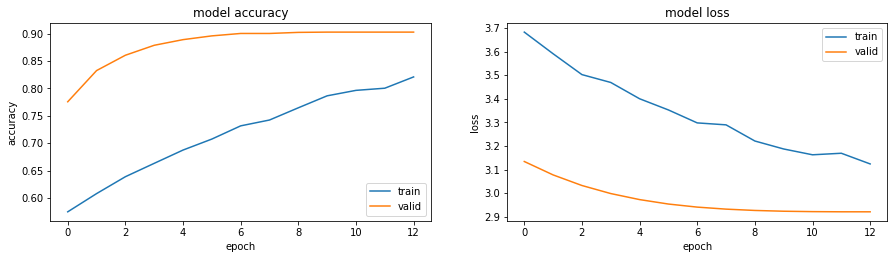


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.91479, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91479 to 0.93976, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.93976 to 0.96082, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96082 to 0.96523, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.96523 to 0.96572, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.96572 to 0.97551, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.97551

Epoch 8: val_accuracy improved from 0.97551 to 0.97600, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.97600 to 0.97992, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.97992

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_a

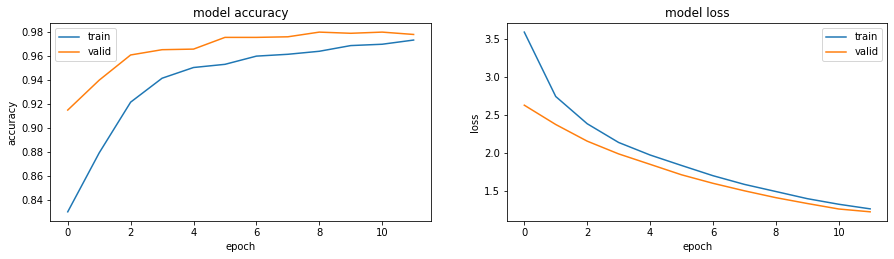


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.60970, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60970 to 0.79873, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.79873 to 0.85700, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.85700 to 0.87953, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.87953 to 0.88981, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.88981 to 0.89324, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89324 to 0.89618, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.89618 to 0.89814, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.89814 to 0.89912, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.89912 to 0.89961, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

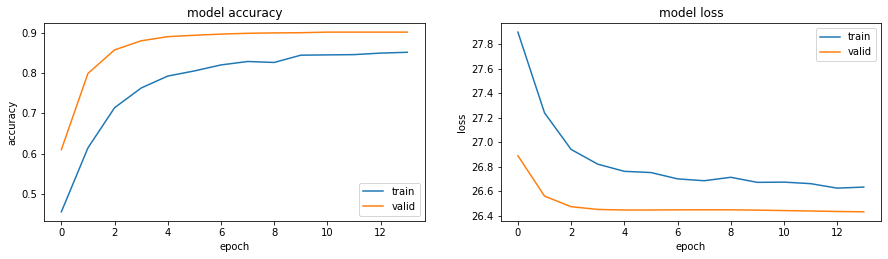


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.93683, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93683 to 0.94809, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94809 to 0.96082, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.96082

Epoch 5: val_accuracy improved from 0.96082 to 0.96474, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.96474 to 0.96621, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.96621

Epoch 8: val_accuracy improved from 0.96621 to 0.96768, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96768 to 0.96915, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.96915

Epoch 11: val_accuracy improved from 0.96915 to 0.97405, saving model to DR.h5

Epoch 12: val_accuracy did not improve f

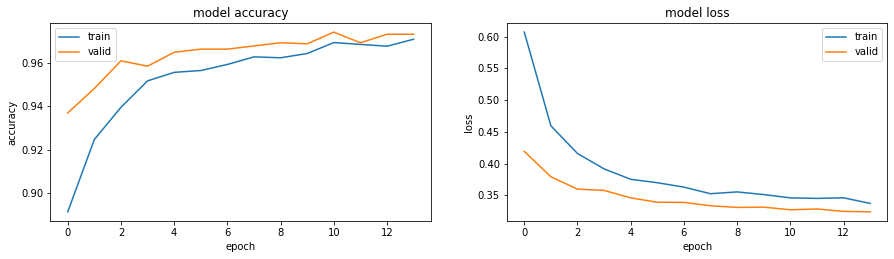


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.33546, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.33546 to 0.81293, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.81293 to 0.89618, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.89618 to 0.90059, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90059 to 0.90255, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90255 to 0.90695, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90695 to 0.90989, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.90989 to 0.91332, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91332 to 0.92067, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.92067 to 0.92605, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

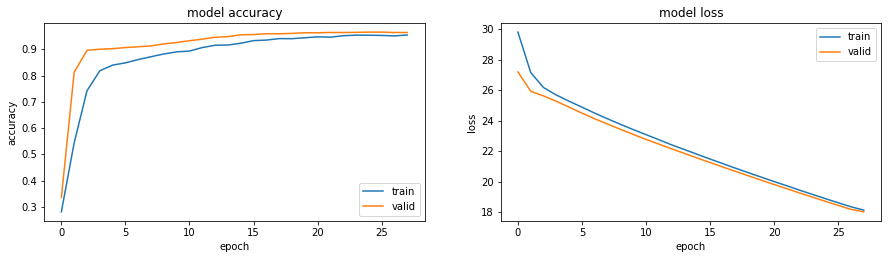


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.96915, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.96915

Epoch 3: val_accuracy improved from 0.96915 to 0.97894, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.97894 to 0.98580, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.98580

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.98580

Epoch 7: val_accuracy did not improve from 0.98580
Epoch 7: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 0.2095 - accuracy: 0.9804

LOSS:	0.20950613915920258 	 ACCURACY:	0.9804113507270813
[0.20950613915920258, 0.9804113507270813]



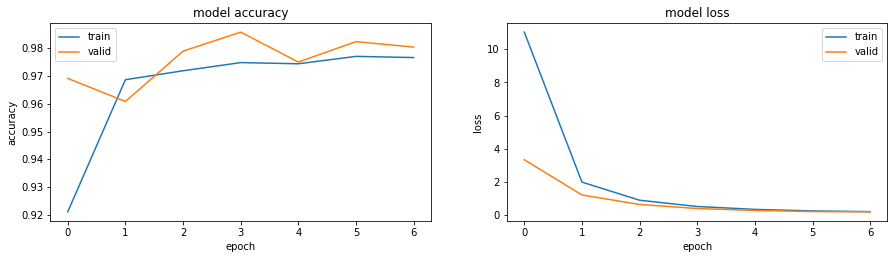


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90304, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90304 to 0.90402, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90402 to 0.90842, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90842 to 0.91724, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.91724 to 0.92507, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.92507 to 0.93634, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.93634 to 0.94270, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.94270 to 0.94956, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.94956 to 0.95495, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.95495

Epoch 11: val_accuracy improved from 0.95495 to 0.95788, saving mo

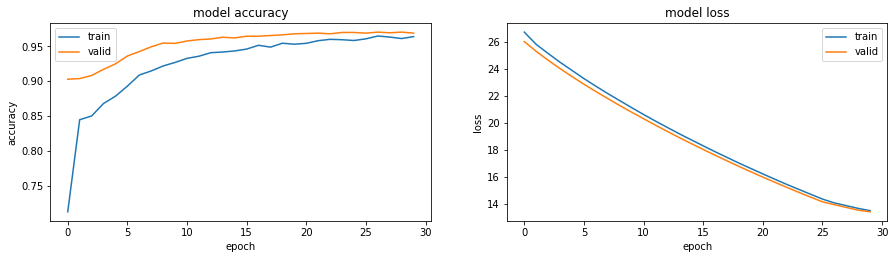


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90206, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90206 to 0.90304, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90304 to 0.90548, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90548 to 0.90695, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90695 to 0.90793, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90793 to 0.91087, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91087 to 0.91479, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91479 to 0.91675, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91675 to 0.92262, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.92262 to 0.92703, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

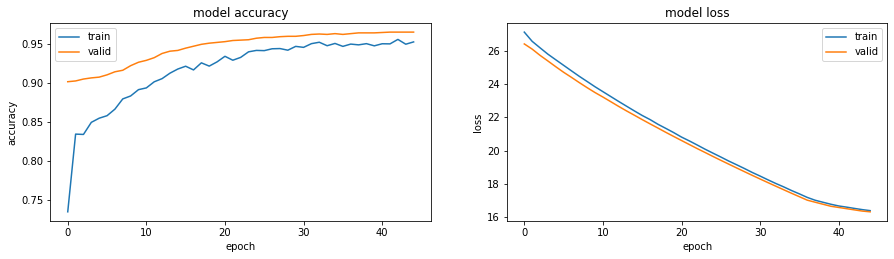


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.21743, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.21743 to 0.23017, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.23017 to 0.24388, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.24388 to 0.26053, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.26053 to 0.27571, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.27571 to 0.29677, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.29677 to 0.31587, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.31587 to 0.32762, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.32762 to 0.34721, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.34721 to 0.36337, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

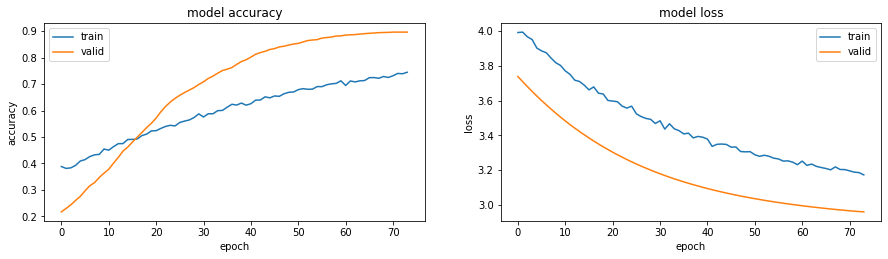


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.89030, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89030 to 0.90108, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90108 to 0.90157, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90157 to 0.90206, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90206 to 0.90255, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.90255

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 7: val_accuracy did not improve from 0.90255

Epoch 8: val_accuracy did not improve from 0.90255
Epoch 8: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 0.5248 - accuracy: 0.9025

LOSS:	0.5248070359230042 	 ACCURACY:	0.9025465250015259
[0.5248070359230042, 0.902546525001

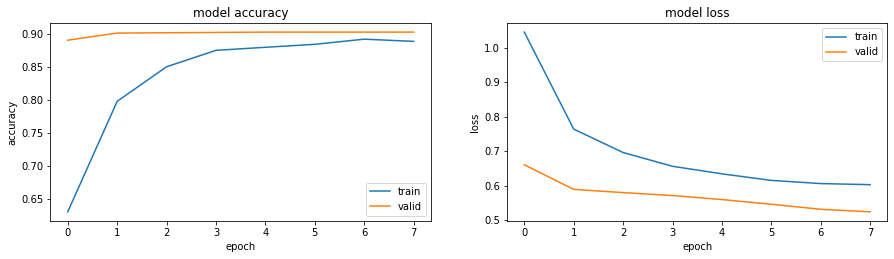


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.96719, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.96719

Epoch 3: val_accuracy improved from 0.96719 to 0.97943, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97943

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.97943

Epoch 6: val_accuracy did not improve from 0.97943
Epoch 6: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 0.2416 - accuracy: 0.9682

LOSS:	0.2415783703327179 	 ACCURACY:	0.9681684374809265
[0.2415783703327179, 0.9681684374809265]



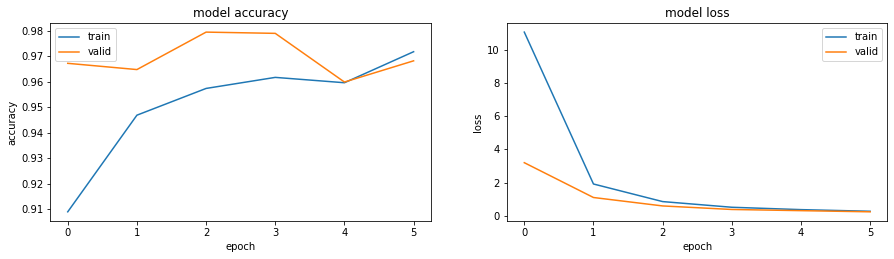


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.90304, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90304

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 4: val_accuracy did not improve from 0.90304

Epoch 5: val_accuracy did not improve from 0.90304
Epoch 5: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 25.0684 - accuracy: 0.9030

LOSS:	25.068357467651367 	 ACCURACY:	0.9030362367630005
[25.068357467651367, 0.9030362367630005]



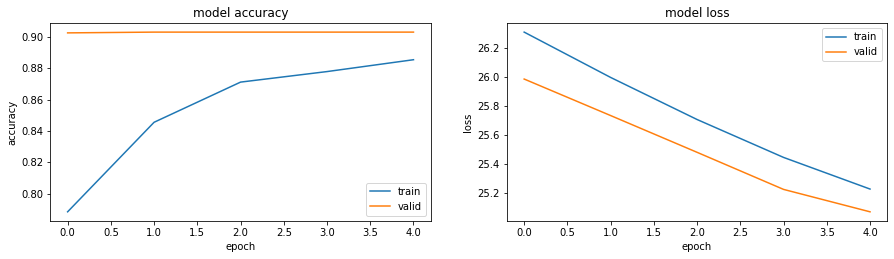


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.91969, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91969 to 0.93291, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.93291 to 0.95201, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.95201 to 0.95837, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.95837 to 0.96180, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.96180 to 0.96964, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.96964 to 0.97111, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.97111

Epoch 9: val_accuracy improved from 0.97111 to 0.97453, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97453 to 0.97551, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.97551 to 0.97649, saving mo

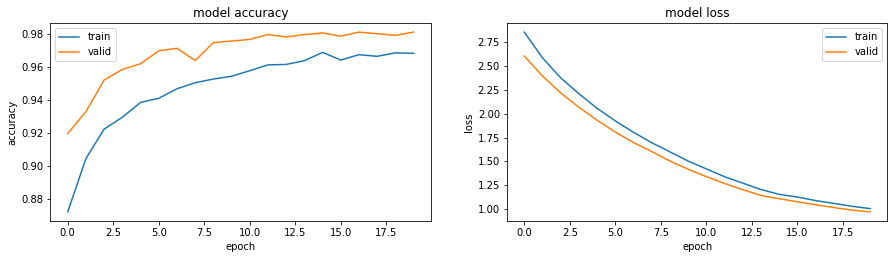


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.86533, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.86533 to 0.89177, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.89177 to 0.89814, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.89814 to 0.90304, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90304 to 0.90597, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90597 to 0.90744, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.90744

Epoch 8: val_accuracy improved from 0.90744 to 0.90793, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.90793 to 0.90842, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.90842

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 11: val_a

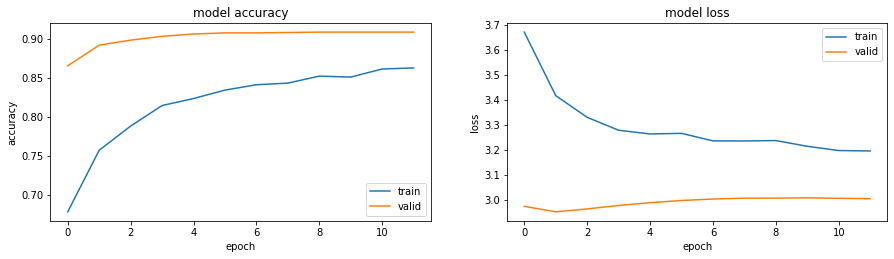


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.94956, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.94956 to 0.97013, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97013 to 0.97796, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.97796 to 0.98188, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.98188

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.98188

Epoch 7: val_accuracy improved from 0.98188 to 0.98286, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.98286 to 0.98335, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.98335 to 0.98384, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.98384 to 0.98531, saving model to DR.h5

Epoch 11: val_ac

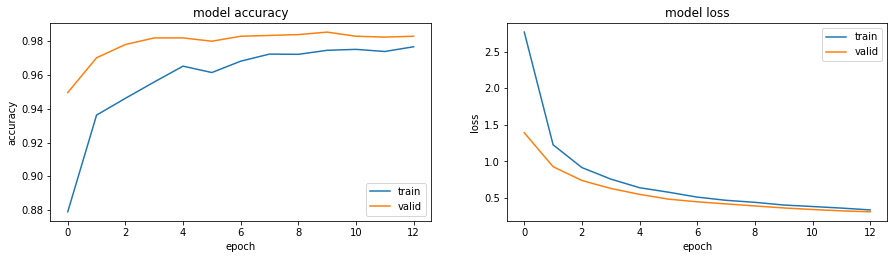


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90304, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90304 to 0.91675, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.91675 to 0.93095, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.93095 to 0.93487, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.93487 to 0.94270, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.94270

Epoch 7: val_accuracy improved from 0.94270 to 0.94466, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.94466 to 0.95201, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.95201

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.95201

Epoch 11: val_accuracy improved from 0.952

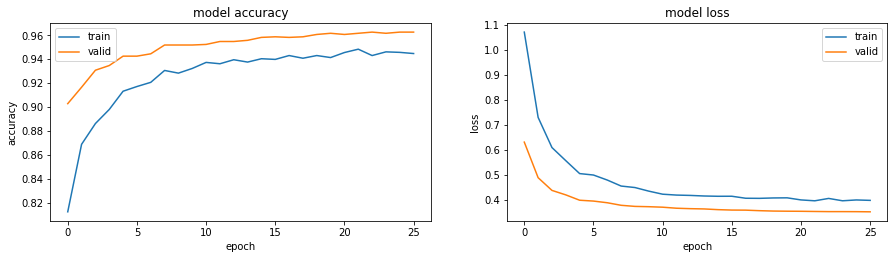


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.62488, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.62488 to 0.69148, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.69148 to 0.74584, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.74584 to 0.78942, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.78942 to 0.83154, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.83154 to 0.85602, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.85602 to 0.87218, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.87218 to 0.88443, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.88443 to 0.89275, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.89275 to 0.90059, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

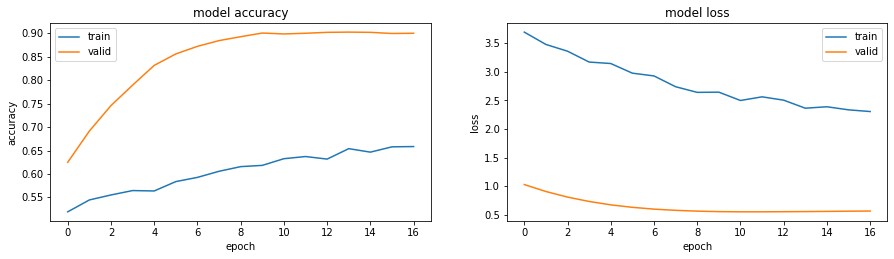


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90500, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90500 to 0.91577, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.91577 to 0.92752, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.92752 to 0.93634, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.93634 to 0.94760, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94760 to 0.95642, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.95642 to 0.96523, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.96523

Epoch 9: val_accuracy improved from 0.96523 to 0.96572, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.96572 to 0.96621, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.96621 to 0.97111, saving mo

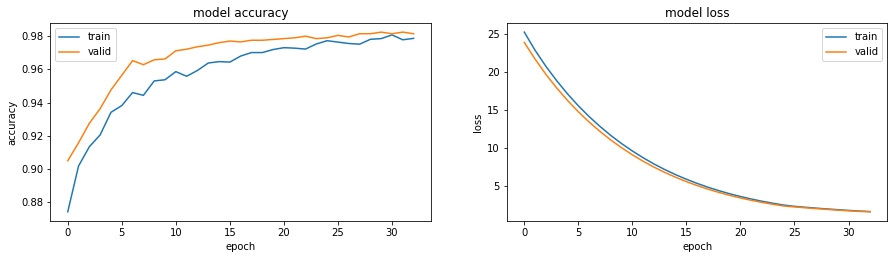


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.82321, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.82321 to 0.84476, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.84476 to 0.86288, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.86288 to 0.87561, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.87561 to 0.88688, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.88688 to 0.89275, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89275 to 0.89569, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.89569 to 0.89863, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.89863 to 0.90059, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.90059 to 0.90157, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

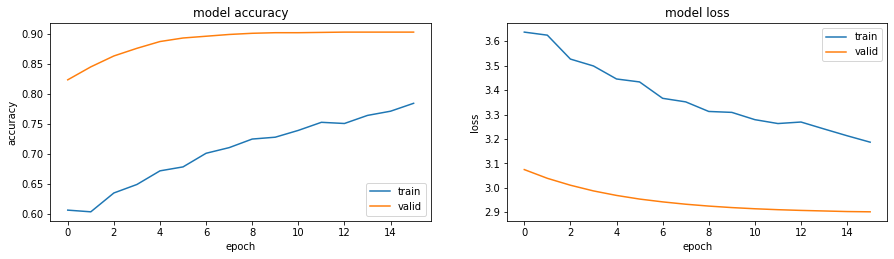


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90353, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90353 to 0.90500, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90500 to 0.90695, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90695 to 0.90989, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90989 to 0.91430, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.91430 to 0.91626, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91626 to 0.92116, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.92116 to 0.92605, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.92605 to 0.93193, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.93193 to 0.93340, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

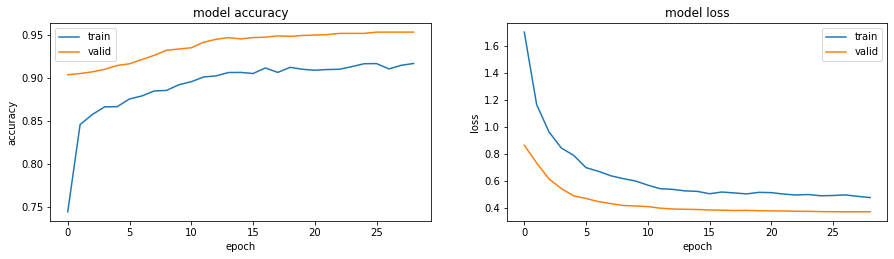


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.58129, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58129 to 0.66259, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.66259 to 0.72625, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.72625 to 0.78942, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.78942 to 0.82468, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.82468 to 0.85945, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.85945 to 0.87610, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.87610 to 0.88688, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.88688 to 0.89618, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.89618 to 0.90059, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

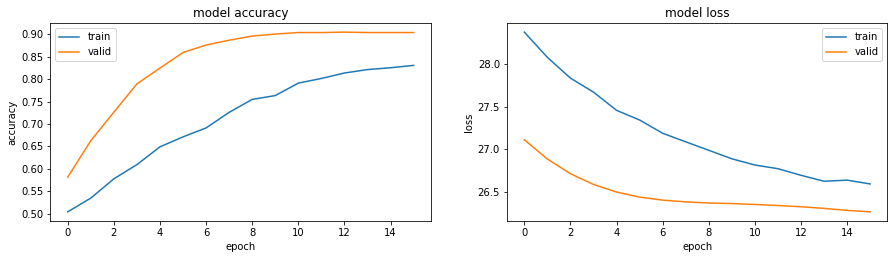


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90940, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90940

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90940

Epoch 4: val_accuracy did not improve from 0.90940
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 2.9870 - accuracy: 0.9079

LOSS:	2.987039089202881 	 ACCURACY:	0.9079334139823914
[2.987039089202881, 0.9079334139823914]



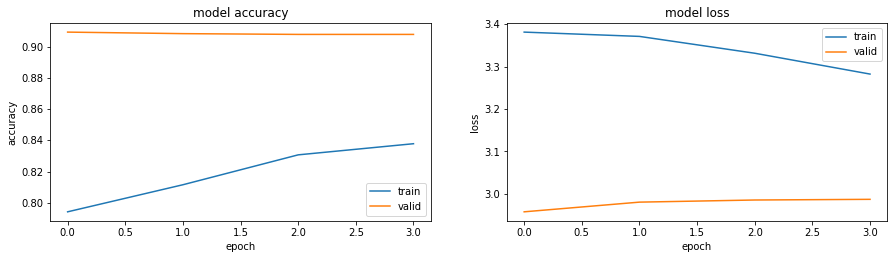


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.09794, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.09794

Epoch 3: val_accuracy improved from 0.09794 to 0.10039, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.10039 to 0.10725, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.10725 to 0.11998, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.11998 to 0.13614, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.13614 to 0.17238, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.17238 to 0.23164, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.23164 to 0.31342, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.31342 to 0.39030, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.39030 to 0.47698, saving mo

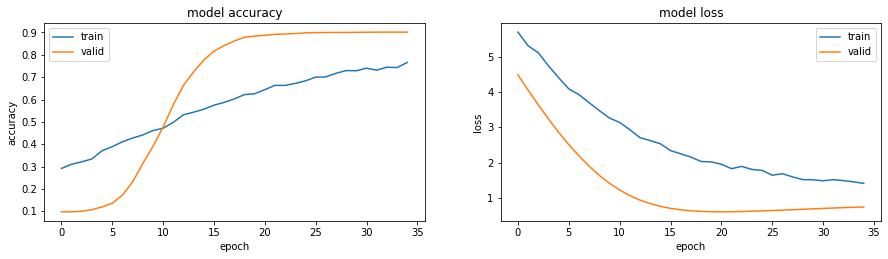


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.23653, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.23653 to 0.30901, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.30901 to 0.39569, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.39569 to 0.48188, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.48188 to 0.56366, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56366 to 0.65034, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.65034 to 0.72037, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.72037 to 0.78404, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.78404 to 0.81685, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.81685 to 0.84917, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

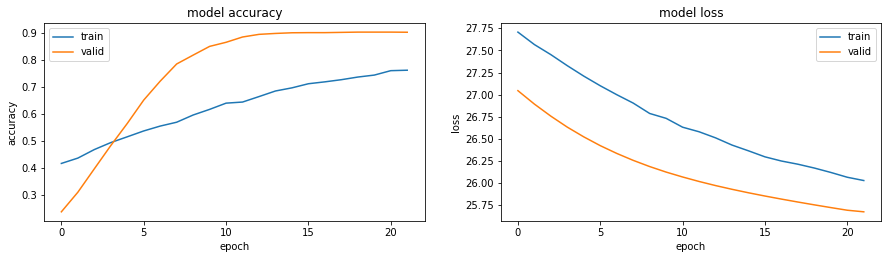


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.52449, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52449 to 0.83986, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.83986 to 0.87023, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.87023 to 0.88394, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.88394 to 0.88932, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.88932 to 0.89324, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89324 to 0.89618, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.89618

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.89618

Epoch 10: val_accuracy did not improve from 0.89618
Epoch 10: early stopping
64/64 [============

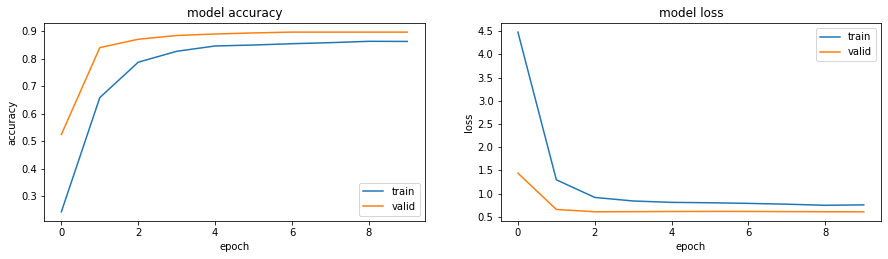


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90353, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90353 to 0.90989, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90989 to 0.91234, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.91234 to 0.91381, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.91381 to 0.91822, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.91822 to 0.92605, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.92605 to 0.93291, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.93291 to 0.93928, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.93928 to 0.94025, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.94025 to 0.94319, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

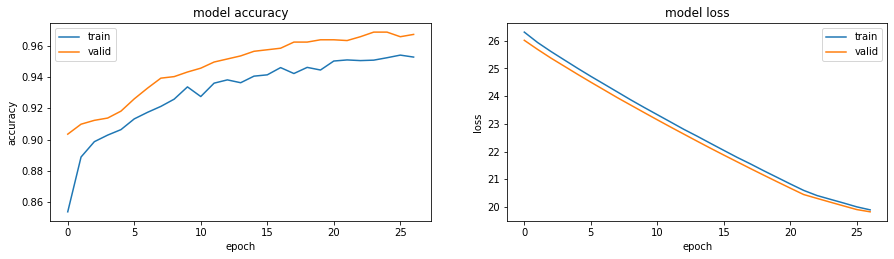


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.96180, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.96180

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.96180

Epoch 4: val_accuracy improved from 0.96180 to 0.98188, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.98188

Epoch 6: val_accuracy improved from 0.98188 to 0.98482, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.98482

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.98482

Epoch 9: val_accuracy did not improve from 0.98482
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.0831 - accuracy: 0.9794

LOSS:	0.08307914

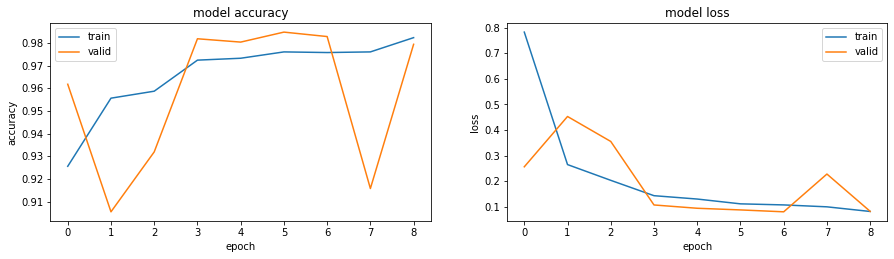


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.7265 - accuracy: 0.9025

LOSS:	0.7264643907546997 	 ACCURACY:	0.9025465250015259
[0.7264643907546997, 0.9025465250015259]



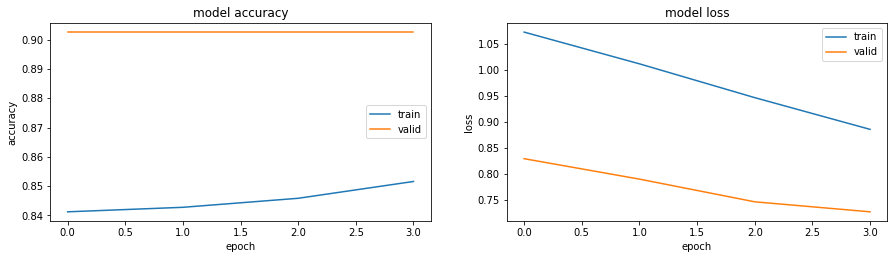


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.73947, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.73947 to 0.74976, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.74976 to 0.75661, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.75661 to 0.76298, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.76298 to 0.77522, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.77522 to 0.78404, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.78404 to 0.79187, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.79187 to 0.79971, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.79971 to 0.80803, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.80803 to 0.81195, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

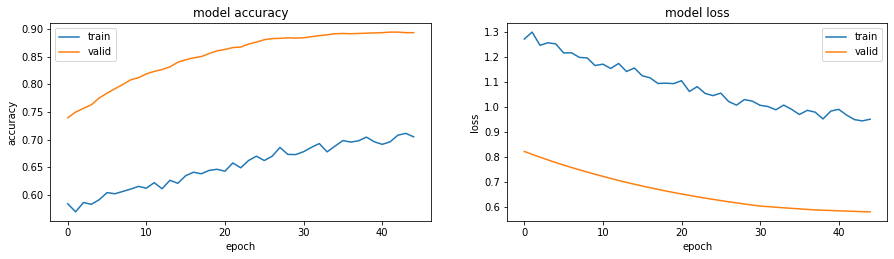


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.96033, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.96033 to 0.96719, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96719 to 0.97551, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97551

Epoch 5: val_accuracy improved from 0.97551 to 0.97943, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.97943

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.97943

Epoch 8: val_accuracy did not improve from 0.97943
Epoch 8: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 3.9574 - accuracy: 0.9785

LOSS:	3.9573943614959717 	 ACCURACY:	0.9784525036811829
[3.9573943614959717, 0.9784525036811829]



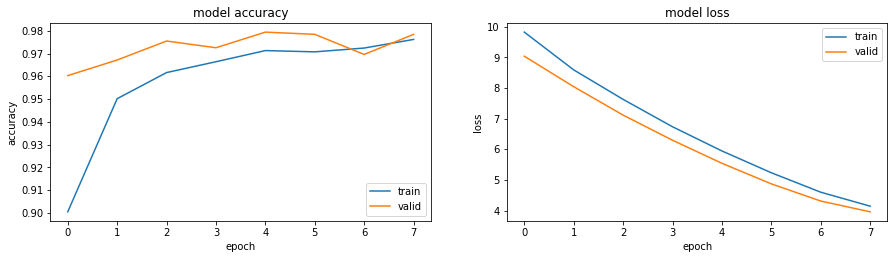


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 1.3567 - accuracy: 0.9025

LOSS:	1.356745958328247 	 ACCURACY:	0.9025465250015259
[1.356745958328247, 0.9025465250015259]



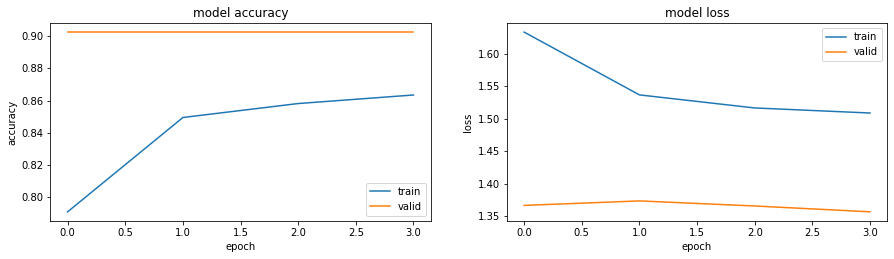


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.93536, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93536 to 0.96425, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.96425

Epoch 4: val_accuracy improved from 0.96425 to 0.96866, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.96866 to 0.97649, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.97649

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.97649

Epoch 8: val_accuracy improved from 0.97649 to 0.97796, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.97796

Epoch 10: val_accuracy improved from 0.97796 to 0.97894, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.97894

Epoch 12: ReduceL

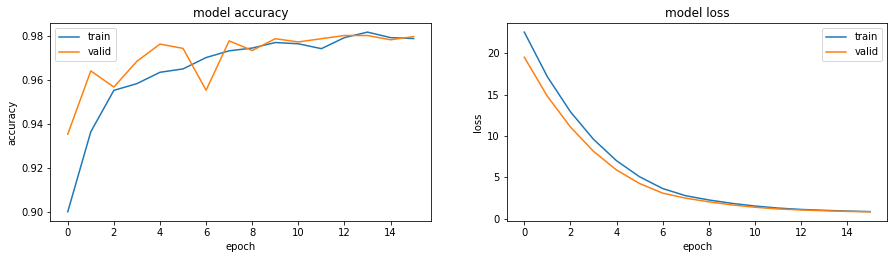


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90891, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90891 to 0.92752, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.92752 to 0.93340, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.93340 to 0.93634, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.93634 to 0.94123, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94123 to 0.94515, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.94515 to 0.94809, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.94809

Epoch 9: val_accuracy improved from 0.94809 to 0.94907, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.94907

Epoch 11: val_accuracy improved from 0.94907 to 0.95250, saving model to DR.h5

Epoch 12: val

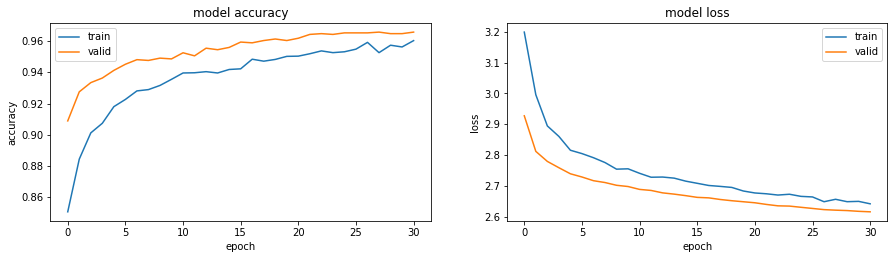


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90206, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90206

Epoch 3: val_accuracy improved from 0.90206 to 0.90597, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90597 to 0.90891, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90891 to 0.90989, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90989 to 0.91234, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91234 to 0.91577, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91577 to 0.92018, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.92018 to 0.92214, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.92214 to 0.92703, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.92703 to 0.93046, saving mo

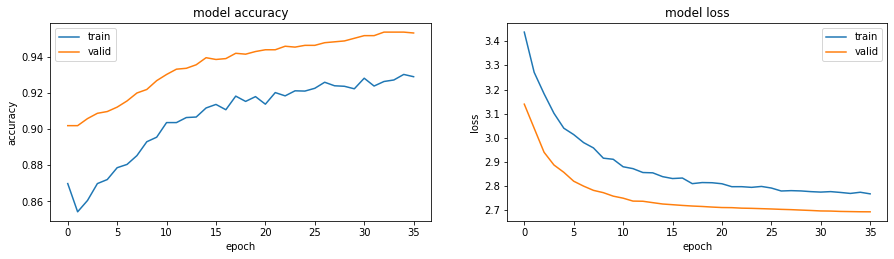


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.16601, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.16601 to 0.26494, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.26494 to 0.44123, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.44123 to 0.62635, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62635 to 0.75906, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.75906 to 0.83056, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.83056 to 0.86141, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.86141 to 0.88100, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.88100 to 0.88981, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.88981 to 0.89422, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

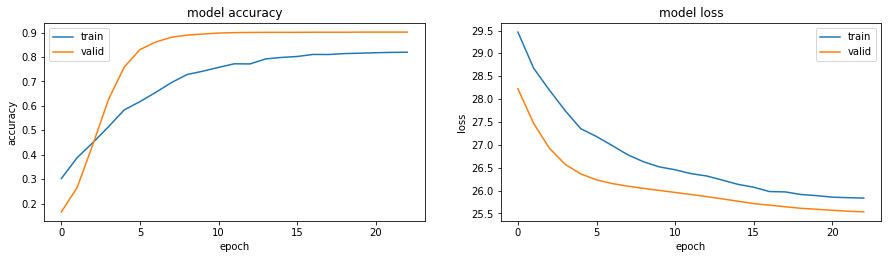


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.88541, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.88541 to 0.89422, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.89422 to 0.89667, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.89667 to 0.89912, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.89912 to 0.90010, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90010 to 0.90255, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90255 to 0.90500, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90500

Epoch 9: val_accuracy improved from 0.90500 to 0.90891, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.90891 to 0.91136, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.91136 to 0.91185, saving mo

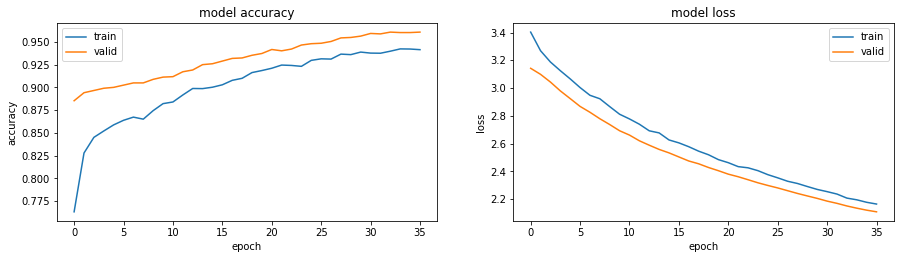


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.96915, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.96915

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.96915

Epoch 5: val_accuracy did not improve from 0.96915
Epoch 5: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.1399 - accuracy: 0.9594

LOSS:	0.13993659615516663 	 ACCURACY:	0.9593535661697388
[0.13993659615516663, 0.9593535661697388]



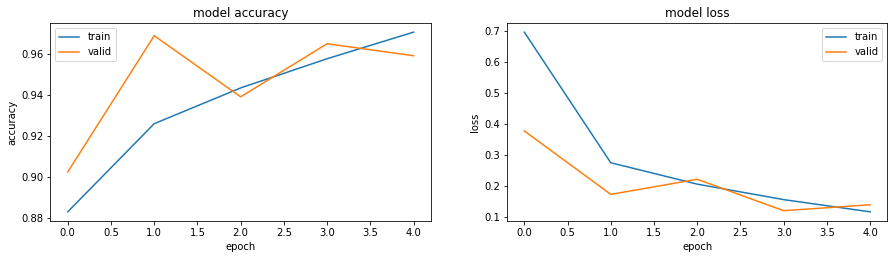


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.95788, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.95788 to 0.96474, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96474 to 0.96768, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96768 to 0.97209, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97209 to 0.97405, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.97405

Epoch 7: val_accuracy improved from 0.97405 to 0.97551, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.97551

Epoch 9: val_accuracy improved from 0.97551 to 0.97796, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97796 to 0.97845, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.97845

Epoch 12: val_accuracy improved from 0.9

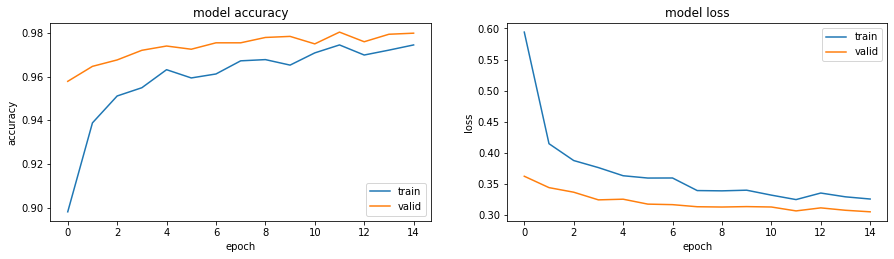


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90989, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90989 to 0.94613, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94613 to 0.95397, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.95397 to 0.95984, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.95984 to 0.96229, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.96229 to 0.97062, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.97062 to 0.97209, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.97209 to 0.97307, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.97307 to 0.97600, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97600 to 0.97796, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

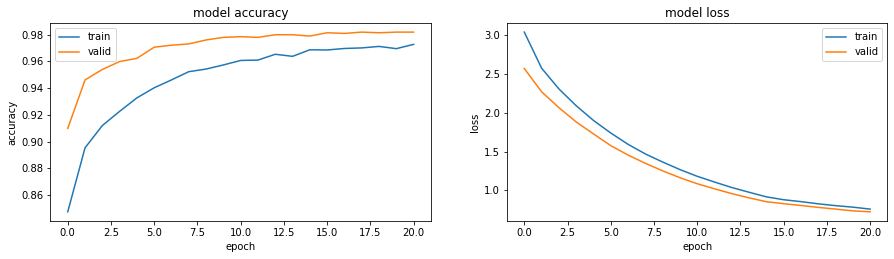


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.90451, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90451 to 0.90548, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90548 to 0.90646, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90646 to 0.90695, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90695 to 0.90842, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90842 to 0.91038, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91038 to 0.91136, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91136 to 0.91185, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91185 to 0.91479, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.91479 to 0.91577, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

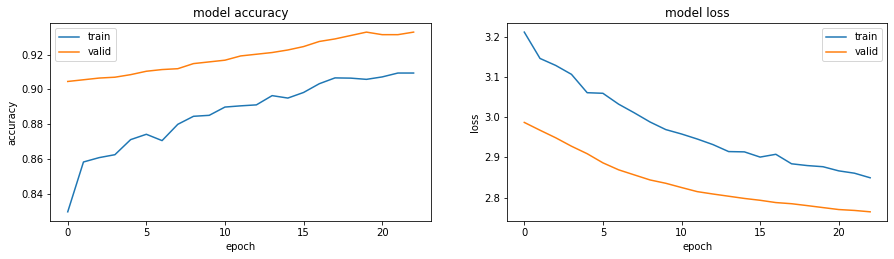


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.1875 - accuracy: 0.9838

Epoch 1: val_accuracy improved from -inf to 0.96572, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.96572 to 0.97943, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97943 to 0.98188, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.98188

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.98188

Epoch 6: val_accuracy improved from 0.98188 to 0.98433, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.98433

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.98433

Epoch 9: val_accuracy improved from 0.98433 to 0.98531, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.98531

Epoch 11: ReduceLROn

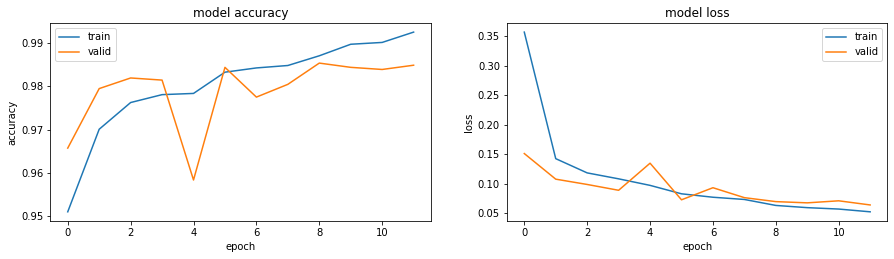


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 3ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.16650, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.16650 to 0.82125, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.82125 to 0.90157, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90157 to 0.90402, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90402 to 0.90500, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.90500

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 7: val_accuracy did not improve from 0.90500

Epoch 8: val_accuracy did not improve from 0.90500
Epoch 8: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.6523 - accuracy: 0.9025

LOSS:	0.6523028016090393 	 ACCURACY:	0.9025465250015259
[0.6523028016090393, 0.902546525001

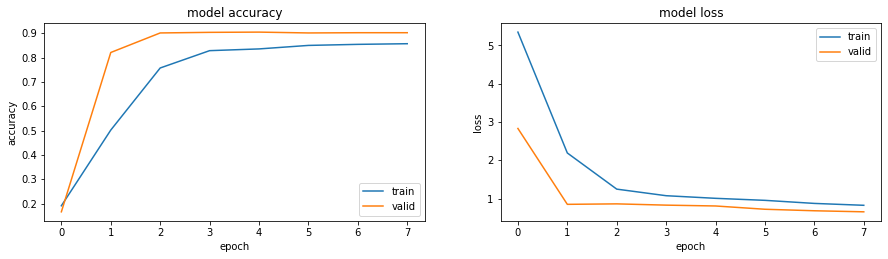


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.94123, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.94123 to 0.95642, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.95642 to 0.96278, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96278 to 0.96915, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.96915 to 0.97160, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97160 to 0.97600, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.97600

Epoch 8: val_accuracy improved from 0.97600 to 0.97698, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.97698 to 0.97992, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97992 to 0.98139, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.98139

Epoch 12: Red

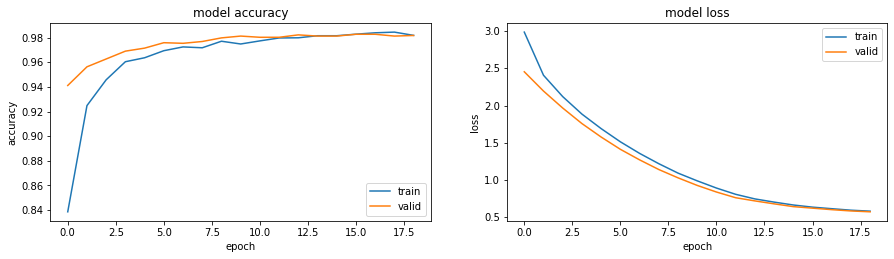


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 25.5165 - accuracy: 0.9025

LOSS:	25.51654624938965 	 ACCURACY:	0.9025465250015259
[25.51654624938965, 0.9025465250015259]



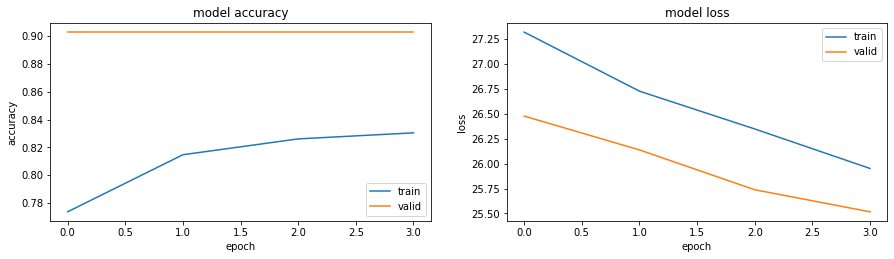


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.95886, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.95886 to 0.97111, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.97111 to 0.97600, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97600 to 0.97796, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.97796

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.97796

Epoch 8: val_accuracy improved from 0.97796 to 0.98433, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.98433

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0

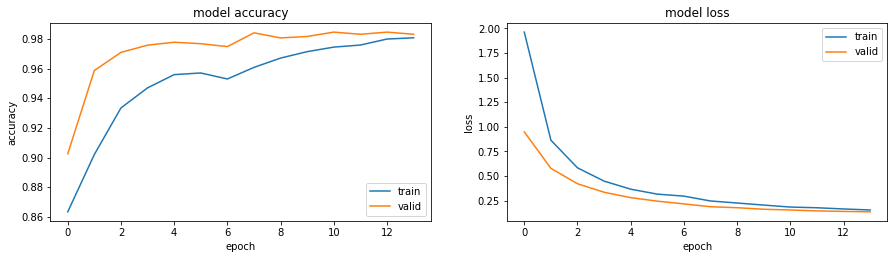


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 5ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90304, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90304

Epoch 3: val_accuracy improved from 0.90304 to 0.90353, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.90353

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 5: val_accuracy did not improve from 0.90353

Epoch 6: val_accuracy did not improve from 0.90353
Epoch 6: early stopping
64/64 [==============================] - 0s 5ms/step - loss: 26.0928 - accuracy: 0.9035

LOSS:	26.092844009399414 	 ACCURACY:	0.9035259485244751
[26.092844009399414, 0.9035259485244751]



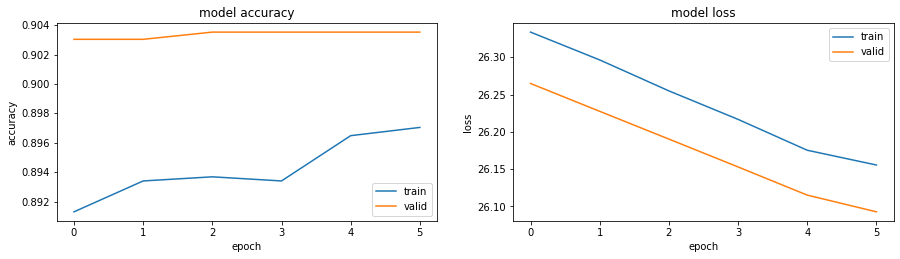


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.92116, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.92116 to 0.95837, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.95837 to 0.96376, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96376 to 0.97747, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97747 to 0.98335, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.98335

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.98335

Epoch 8: val_accuracy did not improve from 0.98335
Epoch 8: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.0893 - accuracy: 0.9809

LOSS:	0.08931448310613632 	 ACCURACY:	0.9809010624885559
[0.08931448310613632, 0.9809010624

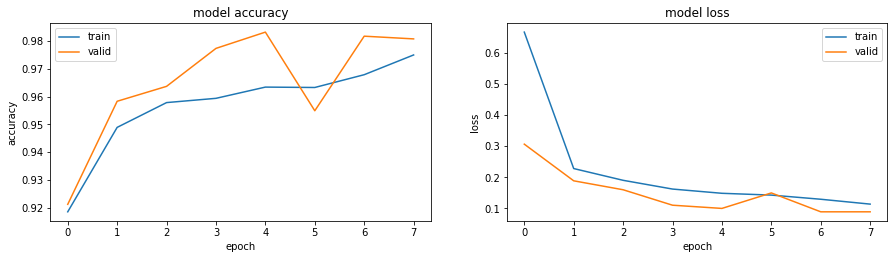


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.91185, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91185 to 0.95397, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.95397 to 0.96278, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96278 to 0.96915, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.96915 to 0.97111, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97111 to 0.97258, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.97258 to 0.97845, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.97845

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.97845

Epoch 10: val_accuracy did not improve from 0.97845
Epoch 10: early stopping
64/64 [============

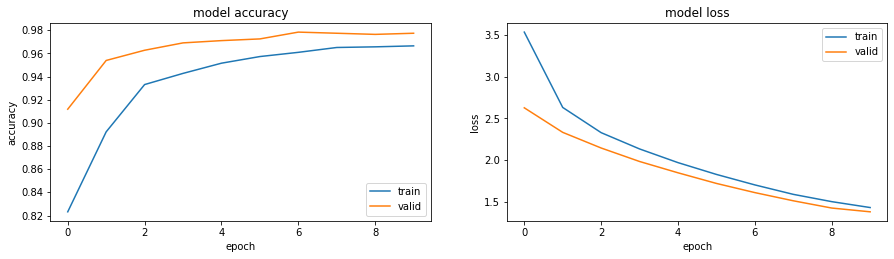


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90108, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90108 to 0.90157, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90157

Epoch 4: val_accuracy improved from 0.90157 to 0.90353, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90353 to 0.90500, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90500 to 0.90646, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90646 to 0.90989, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.90989 to 0.91283, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.91283 to 0.91577, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.91577 to 0.91675, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.91675 to 0.91920, saving mo

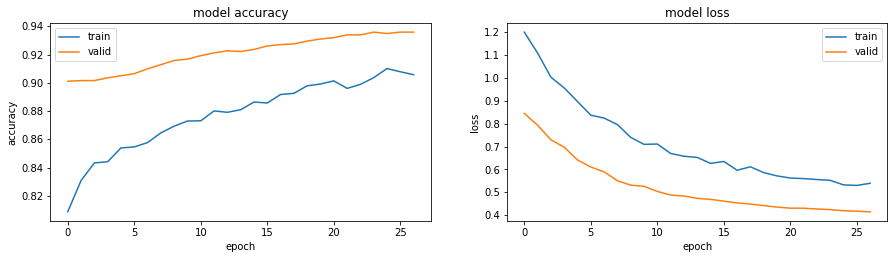


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 1.1631 - accuracy: 0.9025

LOSS:	1.163079857826233 	 ACCURACY:	0.9025465250015259
[1.163079857826233, 0.9025465250015259]



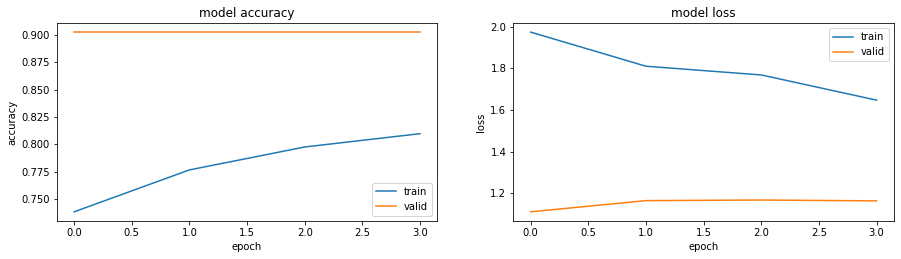


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 26.5637 - accuracy: 0.9025

LOSS:	26.56365394592285 	 ACCURACY:	0.9025465250015259
[26.56365394592285, 0.9025465250015259]



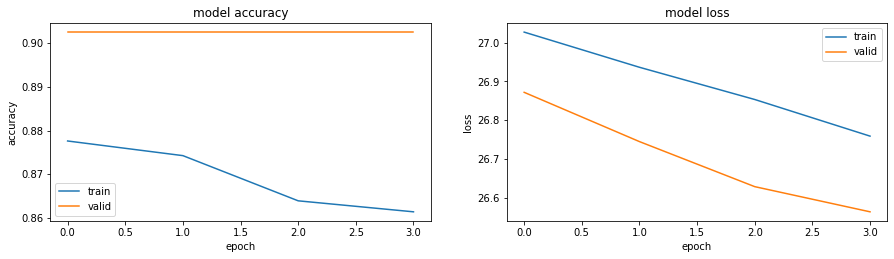


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.90744, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90744 to 0.97356, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97356 to 0.97992, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97992

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.97992

Epoch 6: val_accuracy improved from 0.97992 to 0.98139, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.98139 to 0.98384, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.98384

Epoch 9: val_accuracy improved from 0.98384 to 0.98482, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.98482

Epoch 11: val_accuracy improved from 0.98482 to 0.98531, saving model 

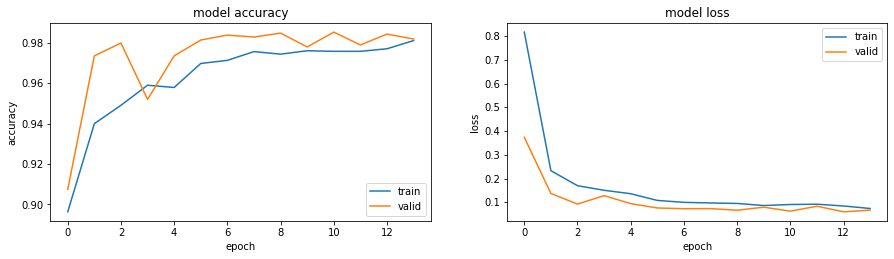


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 0.0641 - accuracy: 0.9848

Epoch 1: val_accuracy improved from -inf to 0.94760, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.94760 to 0.96523, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96523 to 0.97258, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.97258 to 0.97992, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97992 to 0.98188, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.98188

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.98188

Epoch 8: val_accuracy improved from 0.98188 to 0.98384, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.98384

Epoch 10: val_accuracy improved from 0.98384 to 0.98433, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.9843

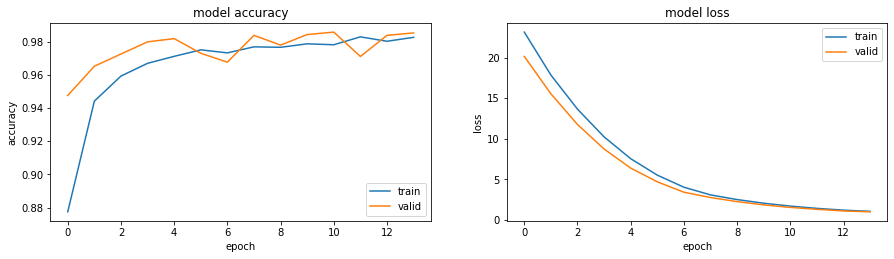


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-01 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.92018, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.92018 to 0.94172, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.94172 to 0.95495, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.95495 to 0.95837, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.95837 to 0.96278, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.96278 to 0.96768, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.96768 to 0.96915, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96915 to 0.97160, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.97160 to 0.97502, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

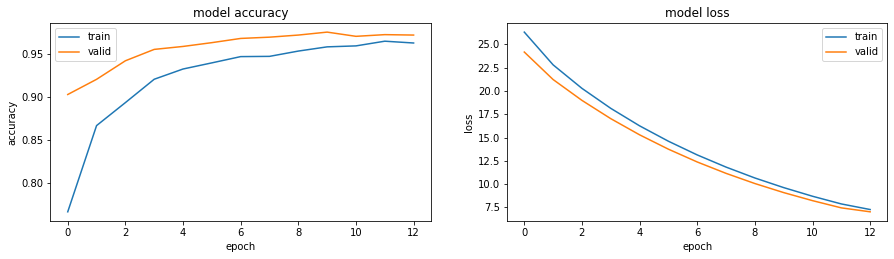


Hyperparameters: [[1.28e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90842, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90842 to 0.91234, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.91234 to 0.91626, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.91626 to 0.92311, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.92311 to 0.92850, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.92850 to 0.93291, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.93291 to 0.93683, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.93683 to 0.93928, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.93928 to 0.94123, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.94123 to 0.94270, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

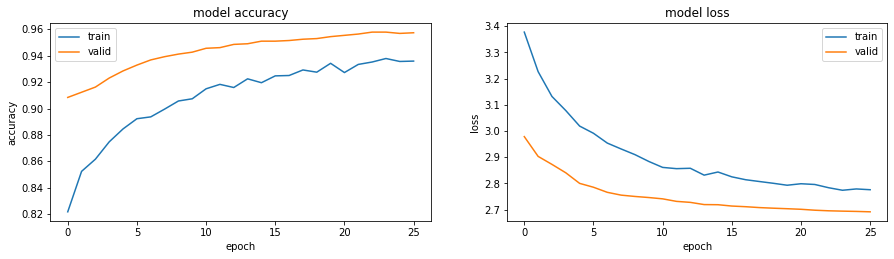


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90206, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90206

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90206

Epoch 4: val_accuracy did not improve from 0.90206
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.5553 - accuracy: 0.9021

LOSS:	0.555253267288208 	 ACCURACY:	0.9020568132400513
[0.555253267288208, 0.9020568132400513]



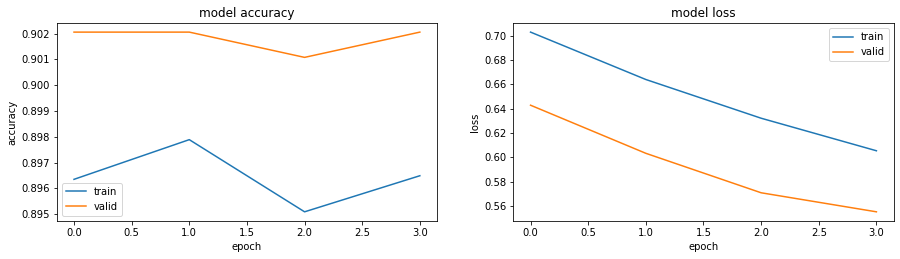


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.45984, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.45984 to 0.70127, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.70127 to 0.83741, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.83741 to 0.87953, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.87953 to 0.89275, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.89275 to 0.89814, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89814 to 0.90059, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.90059 to 0.90206, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.90206 to 0.90255, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.90255

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.9999999848

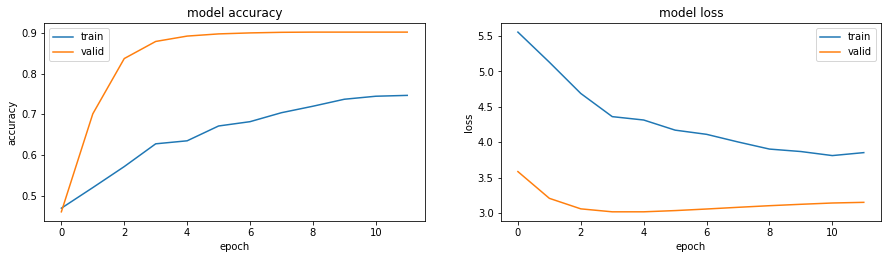


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.89373, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89373 to 0.90255, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 4: val_accuracy did not improve from 0.90255

Epoch 5: val_accuracy did not improve from 0.90255
Epoch 5: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 26.0426 - accuracy: 0.9025

LOSS:	26.042587280273438 	 ACCURACY:	0.9025465250015259
[26.042587280273438, 0.9025465250015259]



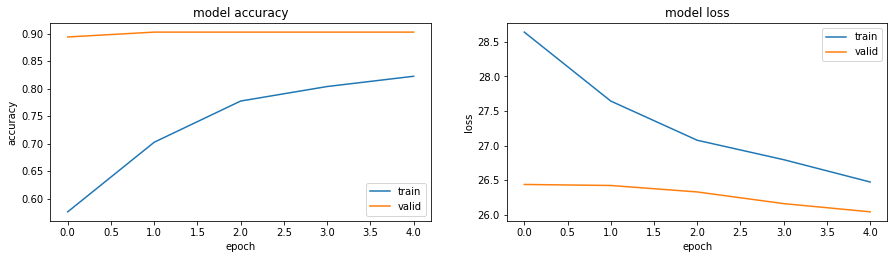


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.89961, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89961 to 0.90255, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 4: val_accuracy did not improve from 0.90255

Epoch 5: val_accuracy did not improve from 0.90255
Epoch 5: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 25.8202 - accuracy: 0.9025

LOSS:	25.8201847076416 	 ACCURACY:	0.9025465250015259
[25.8201847076416, 0.9025465250015259]



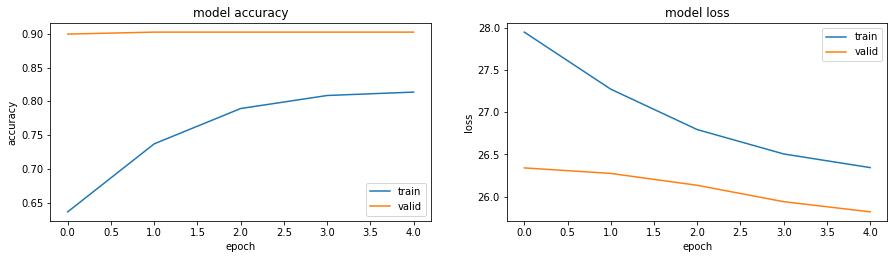


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-01 1.00e+00 3.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.79089, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.79089 to 0.87512, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.87512 to 0.88786, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.88786 to 0.89422, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.89422 to 0.89765, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.89765 to 0.89814, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89814 to 0.89863, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.89863

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.89863

Epoch 10: val_accuracy improved from 0.89863 to 0.89912, saving model to DR.h5

Epoch 11: val_ac

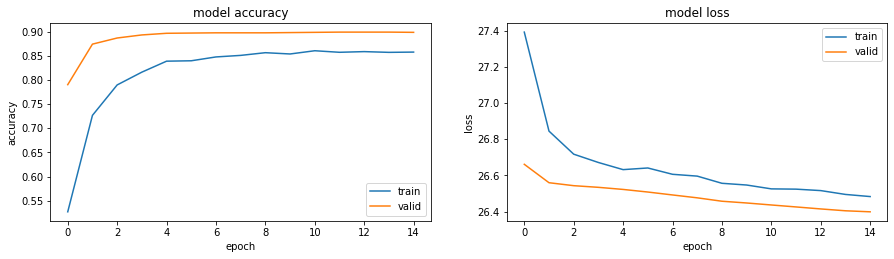


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.69197, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.69197 to 0.82615, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.82615 to 0.87023, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.87023 to 0.88834, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.88834 to 0.89667, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.89667 to 0.90010, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90010 to 0.90108, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90108

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 9: val_accuracy did not improve from 0.90108

Epoch 10: val_accuracy did not improve from 0.90108
Epoch 10: early stopping
64/64 [============

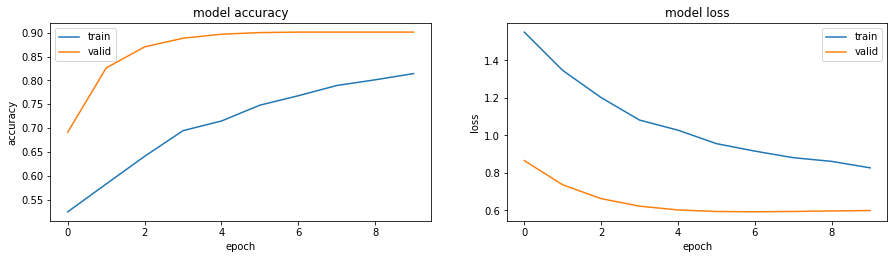


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.89912, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89912 to 0.90206, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90206 to 0.90891, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90891 to 0.92311, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.92311 to 0.93340, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.93340 to 0.93928, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.93928 to 0.94270, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.94270 to 0.95005, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.95005 to 0.95152, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.95152 to 0.95299, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

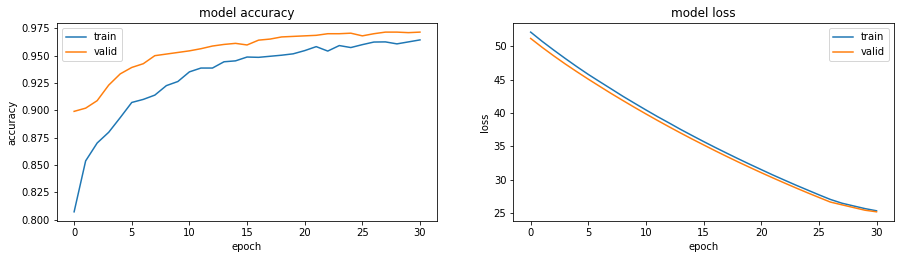


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.89226, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89226 to 0.89569, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.89569

Epoch 4: val_accuracy improved from 0.89569 to 0.89814, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.89814

Epoch 6: val_accuracy improved from 0.89814 to 0.89863, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.89863 to 0.90206, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90206

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 9: val_accuracy did not improve from 0.90206

Epoch 10: val_accuracy did not improve from 0.90206
Epoch 10: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.7884 - acc

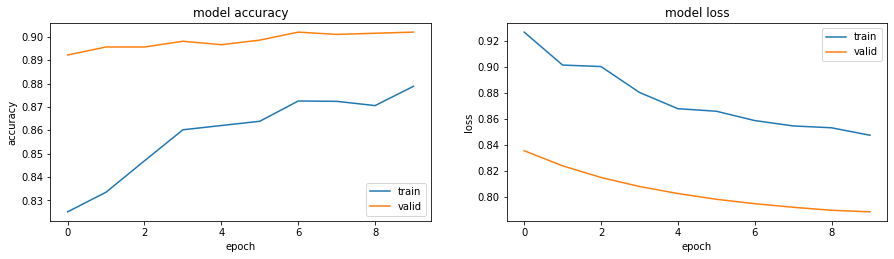


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.42948, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.42948 to 0.64300, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.64300 to 0.78404, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.78404 to 0.86043, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.86043 to 0.88688, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.88688 to 0.90010, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90010 to 0.90255, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90255

Epoch 9: val_accuracy improved from 0.90255 to 0.90304, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.90304 to 0.90353, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.90353

Epoch 12: Red

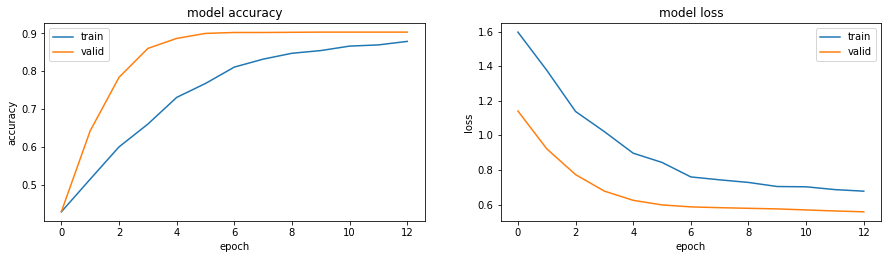


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy did not improve from 0.90255
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 2.9201 - accuracy: 0.9025

LOSS:	2.9201414585113525 	 ACCURACY:	0.9025465250015259
[2.9201414585113525, 0.9025465250015259]



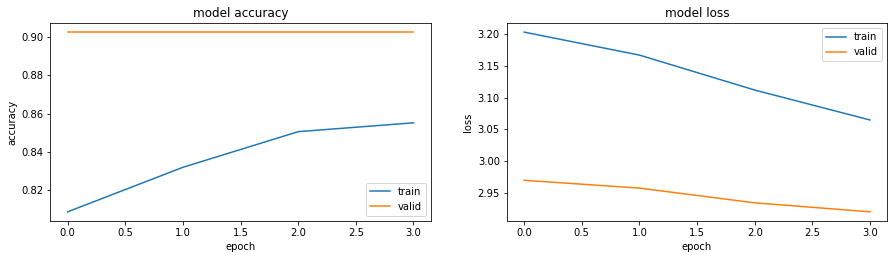


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.95299, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.95299 to 0.97258, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.97258

Epoch 4: val_accuracy improved from 0.97258 to 0.98188, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.98188

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.98188

Epoch 7: val_accuracy did not improve from 0.98188
Epoch 7: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.2317 - accuracy: 0.9520

LOSS:	0.23167353868484497 	 ACCURACY:	0.9520078301429749
[0.23167353868484497, 0.9520078301429749]



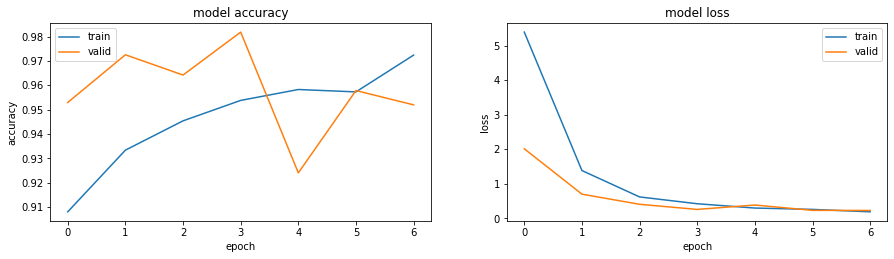


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.98237, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.98237

Epoch 3: val_accuracy improved from 0.98237 to 0.98384, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.98384

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.98384

Epoch 6: val_accuracy did not improve from 0.98384
Epoch 6: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.1518 - accuracy: 0.9770

LOSS:	0.15182043612003326 	 ACCURACY:	0.976983368396759
[0.15182043612003326, 0.976983368396759]



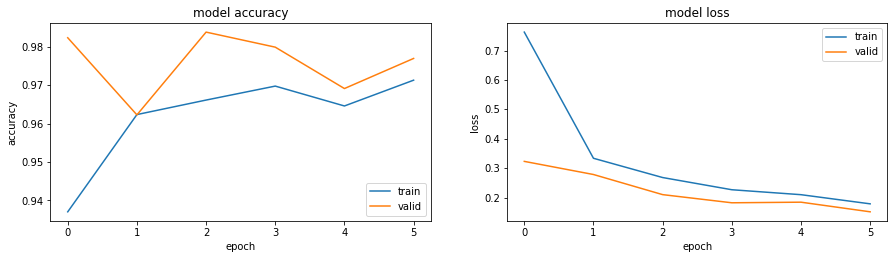


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.89912, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.89912 to 0.90206, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.90206 to 0.90255, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.90255

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 5: val_accuracy did not improve from 0.90255

Epoch 6: val_accuracy did not improve from 0.90255
Epoch 6: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 103.5592 - accuracy: 0.9025

LOSS:	103.55924987792969 	 ACCURACY:	0.9025465250015259
[103.55924987792969, 0.9025465250015259]



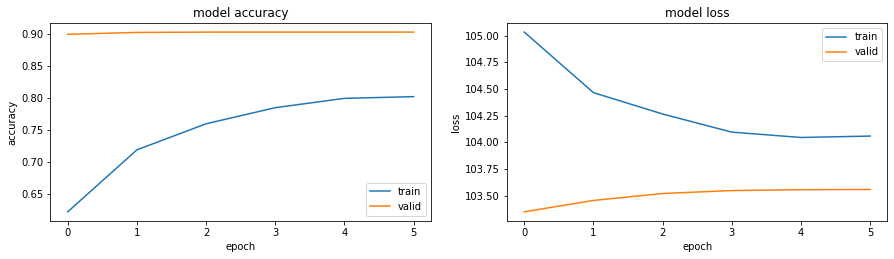


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90304, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90304

Epoch 3: val_accuracy improved from 0.90304 to 0.90500, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.90500 to 0.90793, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90793 to 0.91234, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.91234 to 0.91773, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91773 to 0.92311, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.92311 to 0.92703, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.92703 to 0.93585, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.93585 to 0.93830, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.93830 to 0.93976, saving mo

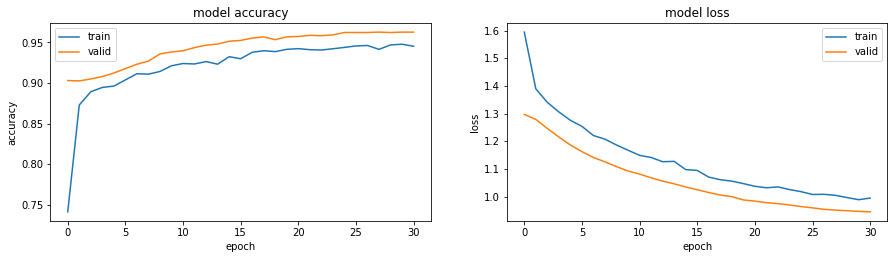


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90255 to 0.96327, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96327 to 0.97111, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97111

Epoch 5: val_accuracy improved from 0.97111 to 0.97747, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97747 to 0.97796, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.97796

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.97796

Epoch 9: val_accuracy did not improve from 0.97796
Epoch 9: early stopping
64/64 [==============================] - 0s 3ms/step - loss: 0.1821 - accuracy: 0.9726

LOSS:	0.18206891417503357 	 ACCURACY:	0

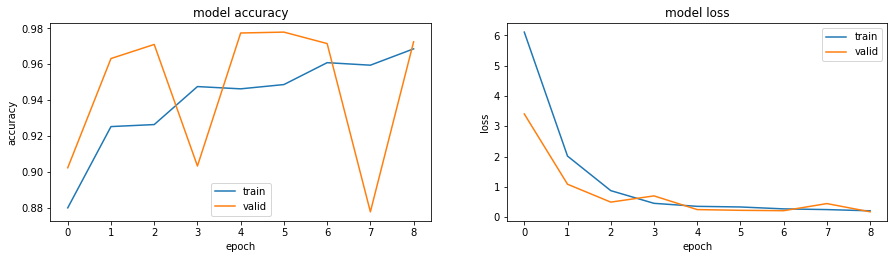


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.54261, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54261 to 0.82958, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.82958 to 0.88834, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.88834 to 0.89814, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.89814 to 0.90157, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90157 to 0.90255, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.90255

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.90255

Epoch 9: val_accuracy did not improve from 0.90255
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 1.9684 - accuracy: 0.9025

LOSS:	1.9684

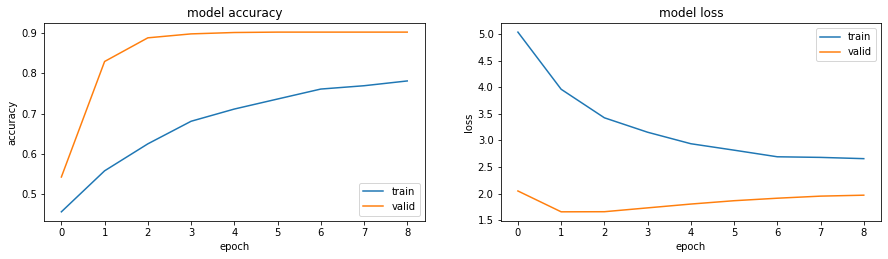


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.93976, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93976 to 0.97356, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97356 to 0.98237, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.98237

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.98237

Epoch 6: val_accuracy improved from 0.98237 to 0.98286, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.98286

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.98286

Epoch 9: val_accuracy did not improve from 0.98286
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.6024 - accurac

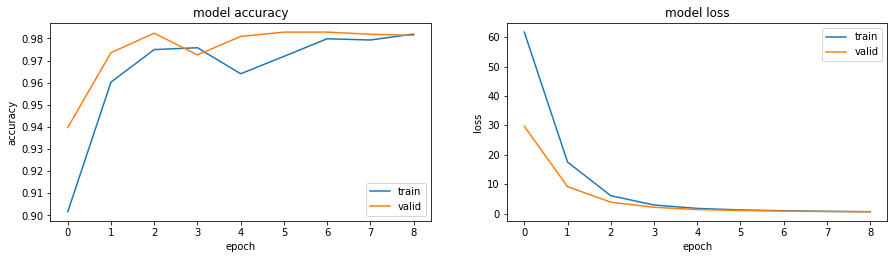


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90206, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90206 to 0.90255, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.90255

Epoch 4: val_accuracy improved from 0.90255 to 0.90402, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.90402 to 0.90597, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90597 to 0.91185, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.91185 to 0.91822, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.91822 to 0.92605, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.92605 to 0.92899, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.92899 to 0.93732, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.93732 to 0.94368, saving mo

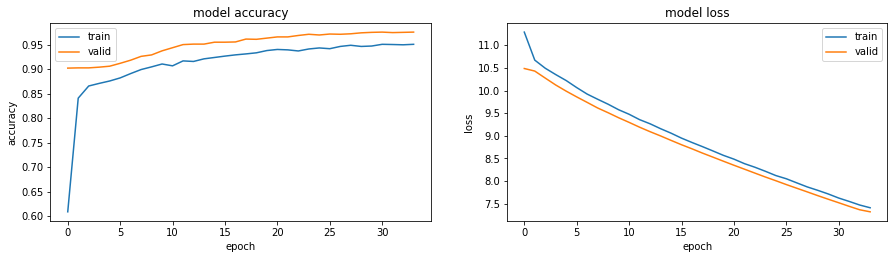


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90646, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.90646 to 0.92311, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.92311 to 0.93340, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.93340 to 0.94270, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.94270 to 0.94956, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.94956 to 0.95446, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.95446

Epoch 8: val_accuracy improved from 0.95446 to 0.95739, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.95739 to 0.96033, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.96033

Epoch 11: val_accuracy improved from 0.96033 to 0.96131, saving model to DR.h5

Epoch 12: val

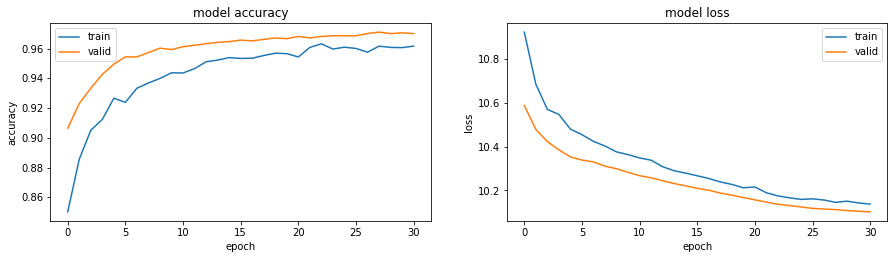


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.95739, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.95739 to 0.96572, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.96572 to 0.97600, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97600

Epoch 5: val_accuracy improved from 0.97600 to 0.97943, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97943 to 0.98237, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.98237

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.98237

Epoch 9: val_accuracy did not improve from 0.98237
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.4480 - accuracy: 0.9804

LOSS:	0.4479895234107971 	 ACCURACY:	0.

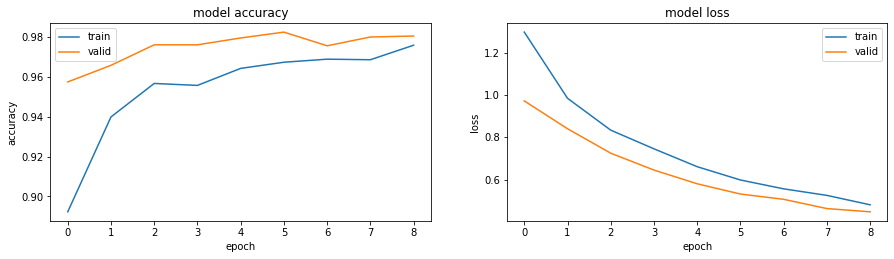


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.91773, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91773 to 0.93438, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.93438 to 0.94466, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.94466 to 0.95348, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.95348 to 0.95739, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.95739 to 0.96327, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.96327 to 0.96523, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.96523 to 0.96572, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96572 to 0.96768, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.96768 to 0.96866, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

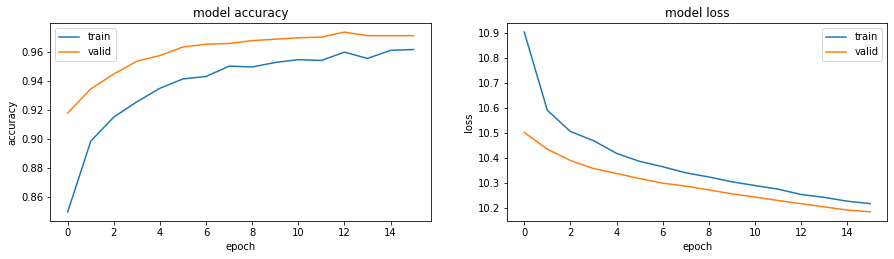


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90206, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90206

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.90206

Epoch 4: val_accuracy did not improve from 0.90206
Epoch 4: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 10.5299 - accuracy: 0.9021

LOSS:	10.529885292053223 	 ACCURACY:	0.9020568132400513
[10.529885292053223, 0.9020568132400513]



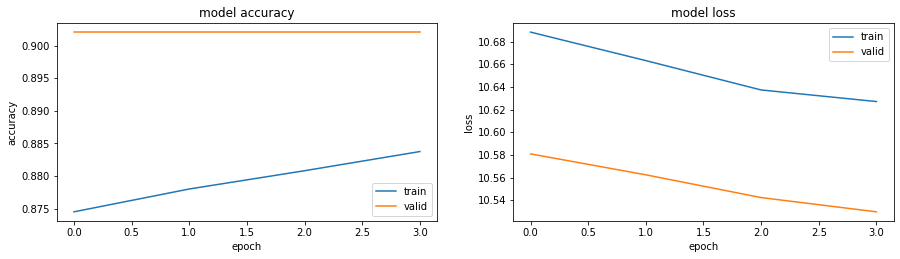


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: val_accuracy improved from 0.90255 to 0.90353, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.90353

Epoch 5: val_accuracy improved from 0.90353 to 0.90402, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90402 to 0.90451, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.90451

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 8: val_accuracy did not improve from 0.90451

Epoch 9: val_accuracy did not improve from 0.90451
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 101.9565 - accuracy: 0.9040

LOSS:	101.95647430419922 	 ACCURACY:	0.9040156602859497
[101.956

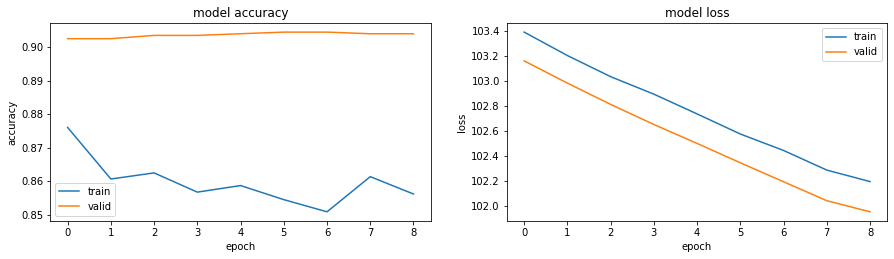


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.91479, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.91479 to 0.94613, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.94613

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.94613

Epoch 5: val_accuracy improved from 0.94613 to 0.96523, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.96523

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.96523

Epoch 8: val_accuracy improved from 0.96523 to 0.96719, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.96719 to 0.97894, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.97894

Epoch 11: ReduceLROn

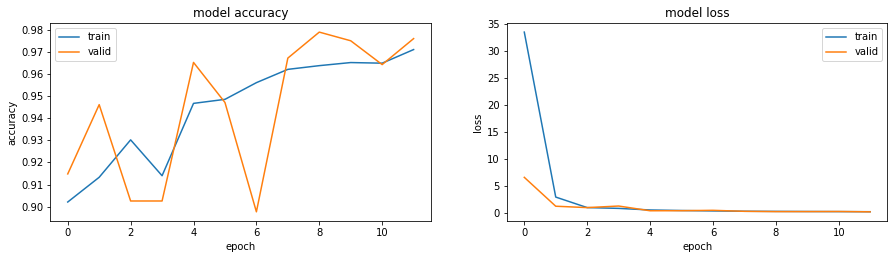


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.71303, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.71303 to 0.85945, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.85945 to 0.88688, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.88688 to 0.89814, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.89814 to 0.90304, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90304 to 0.90451, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.90451

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.90451

Epoch 9: val_accuracy did not improve from 0.90451
Epoch 9: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 1.4803 - accuracy: 0.9040

LOSS:	1.4802

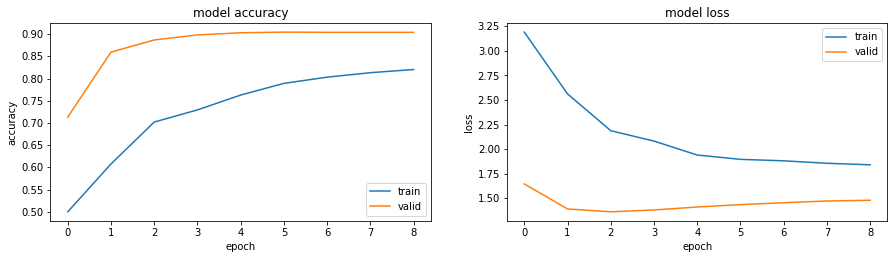


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.96964, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.96964

Epoch 3: val_accuracy improved from 0.96964 to 0.97747, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97747

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.97747

Epoch 6: val_accuracy did not improve from 0.97747
Epoch 6: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.1730 - accuracy: 0.9745

LOSS:	0.17295563220977783 	 ACCURACY:	0.9745347499847412
[0.17295563220977783, 0.9745347499847412]



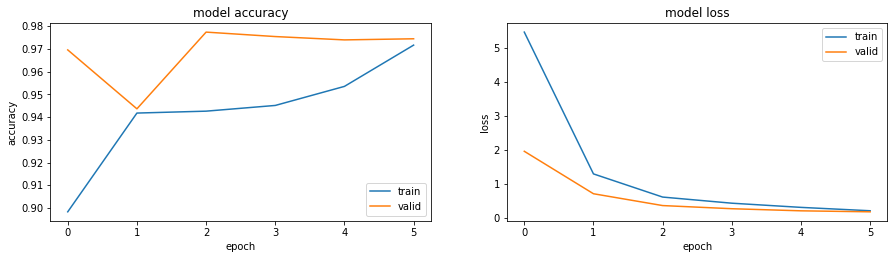


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.90255, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.90255

Epoch 3: val_accuracy improved from 0.90255 to 0.90304, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.90304

Epoch 5: val_accuracy improved from 0.90304 to 0.90500, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.90500 to 0.90646, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.90646 to 0.90695, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.90695

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.90695

Epoch 10: val_accuracy improved from 0.90695 to 0.90891, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.90891

Epoch 12: val_acc

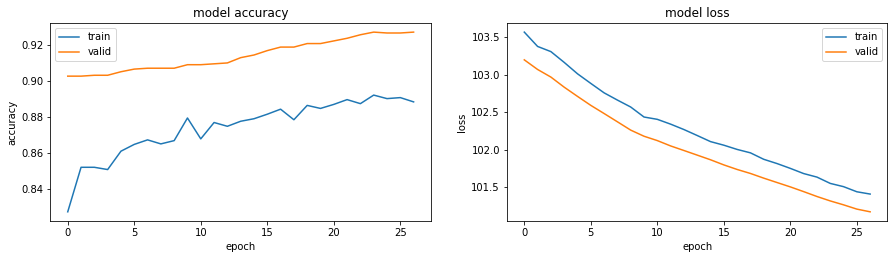


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
64/64 [==============================] - 1s 5ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.94662, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.94662 to 0.94760, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.94760 to 0.96229, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96229 to 0.97600, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.97600

Epoch 6: val_accuracy improved from 0.97600 to 0.98041, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.98041 to 0.98237, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.98237

Epoch 9: val_accuracy improved from 0.98237 to 0.98286, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.98286

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 11: val_accuracy did not improve fro

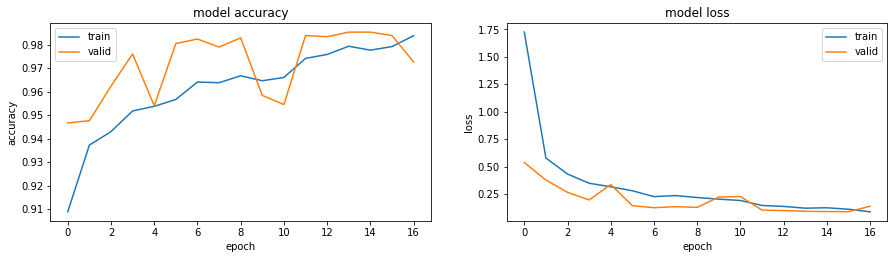


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.96817, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.96817 to 0.97405, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.97405 to 0.97796, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.97796

Epoch 5: val_accuracy improved from 0.97796 to 0.98090, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.98090

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.98090

Epoch 8: val_accuracy did not improve from 0.98090
Epoch 8: early stopping
64/64 [==============================] - 0s 4ms/step - loss: 0.1438 - accuracy: 0.9799

LOSS:	0.14384011924266815 	 ACCURACY:	0.9799216389656067
[0.14384011924266815, 0.9799216389656067]



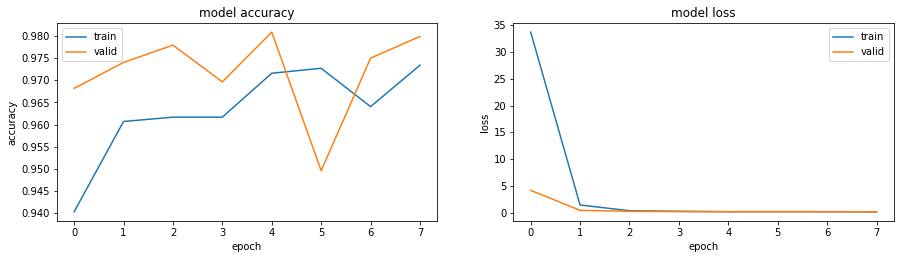


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]
64/64 [==============================] - 0s 4ms/step - loss: 1.0125 - accuracy: 0.9853

Epoch 1: val_accuracy improved from -inf to 0.93438, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.93438 to 0.95886, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.95886 to 0.96278, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.96278 to 0.97111, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.97111 to 0.97356, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.97356 to 0.97649, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.97649 to 0.97747, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.97747 to 0.97796, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.97796 to 0.97992, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.97992

Epoch 11: val_accuracy improved from 0.97992 to 0.98139, saving mo

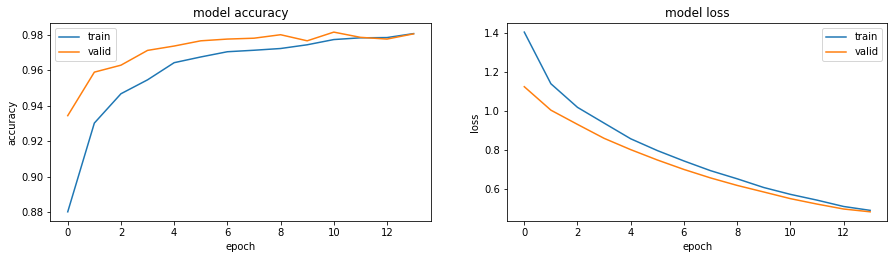

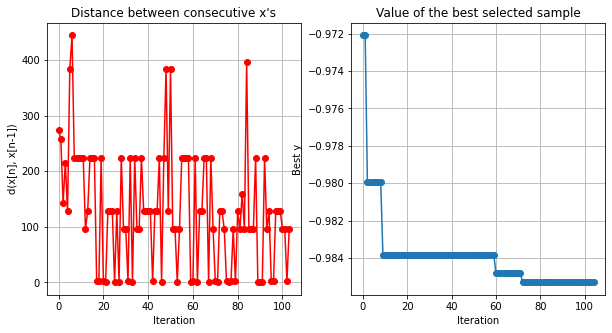

In [20]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [21]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	128.0
	learning_rate:	0.0001
	l2:	0.1
	activation:	elu
	rate:	0.3
	batch:	128.0
 optim RMSprop
optimized accuracy: [0.98530853]


In [22]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 246,146
Trainable params: 246,146
Non-trainable params: 0
_________________________________________________________________
64/64 [==============================] - 0s 3ms/step - loss: 1.0125 - accuracy: 0.9853
Restored model, accuracy: 98.53%


In [23]:
best_model.evaluate(features_valid, y_test)

64/64 [==============================] - 0s 3ms/step - loss: 1.0125 - accuracy: 0.9853


[1.0124714374542236, 0.9853085279464722]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, precision, recall, f1_score))

In [24]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Thu Jan  5 10:35:53 2023
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           1107.5380606651306 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [25]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

In [26]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [27]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

32/32 [==============================] - 8s 215ms/step


In [28]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

32/32 [==============================] - 0s 3ms/step - loss: 1.0092 - accuracy: 0.9863
Restored model, accuracy: 98.63%


In [29]:
best_model.evaluate(features_test, y_test)

32/32 [==============================] - 0s 3ms/step - loss: 1.0092 - accuracy: 0.9863


[1.009194254875183, 0.9863147735595703]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, precision, recall, f1_score))